# Alzheimer Diease Prediction using Machine Learning
## Clinical Data Pipeline for Alzheimer's Disease Diagnosis
## Includes preprocessing, feature selection, model training, and SHAP-based interpretability

In [8]:
## Install the CatBoost library
!pip install catboost

In [9]:
# 📦 Standard Libraries
import warnings                     # Suppress unnecessary warnings
import json                         # Handle JSON file operations (read/write)
import numpy as np                  # Numerical computing library
import pandas as pd                 # Data manipulation & analysis
import matplotlib.pyplot as plt     # Data visualization (static plots)
import seaborn as sns               # Advanced data visualization (statistical plots)
import joblib                       # Save & load ML models/pipelines efficiently
import shap                         # Explainable AI: SHAP values for feature importance

# 📊 Preprocessing & Feature Engineering
from sklearn.preprocessing import StandardScaler, OneHotEncoder   # Normalization & categorical encoding
from sklearn.impute import KNNImputer, SimpleImputer              # Handling missing values
from sklearn.compose import ColumnTransformer                     # Apply transformations by column type
from sklearn.pipeline import Pipeline                             # Chain preprocessing & modeling steps
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif  # Feature selection techniques
from scipy.stats import pointbiserialr                            # Correlation measure for binary vs continuous features

# 🔀 Model Selection & Evaluation
from sklearn.model_selection import (
    train_test_split,            # Split data into train/test sets
    GridSearchCV,                # Hyperparameter tuning with grid search
    StratifiedKFold              # Stratified cross-validation
)
from sklearn.metrics import (
    accuracy_score,              # Classification accuracy
    classification_report,       # Precision, Recall, F1-score summary
    confusion_matrix,            # Confusion matrix for predictions
    roc_curve,                   # Receiver Operating Characteristic curve
    precision_recall_curve,      # Precision-Recall curve
    roc_auc_score,               # AUC score for ROC
    average_precision_score,     # Average precision (PR curve area)
    auc                          # Generic Area Under Curve
)
from sklearn.calibration import calibration_curve   # Probability calibration

# ⚙️ Machine Learning Models
from sklearn.tree import DecisionTreeClassifier     # Decision Tree
from sklearn.svm import SVC                         # Support Vector Machine
from sklearn.ensemble import (
    RandomForestClassifier,    # Random Forest
    VotingClassifier,          # Ensemble of multiple models
    GradientBoostingClassifier # Gradient Boosting
)
from xgboost import XGBClassifier                   # Extreme Gradient Boosting (XGBoost)
from catboost import CatBoostClassifier             # CatBoost (handles categorical data well)

# ⚖️ Handling Class Imbalance
from imblearn.combine import SMOTETomek             # Oversample (SMOTE) + Undersample (Tomek Links)

# 🎨 Extra Visualization
import matplotlib.patches as mpatches               # Create custom legend elements for plots

# ⚠️ Suppress warnings for cleaner output
warnings.filterwarnings('ignore')


📊 POINT-BISERIAL CORRELATION ANALYSIS

🔍 DEMOGRAPHIC FEATURES:
----------------------------------------------------------------------------------------------------
 1. EducationLevel            │ █░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░ │ 0.0440 *
                              │ p-value: 0.0416
 2. Gender                    │ ░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░ │ 0.0210 
                              │ p-value: 0.3311
 3. Ethnicity                 │ ░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░ │ 0.0148 
                              │ p-value: 0.4934
 4. Age                       │ ░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░ │ 0.0055 
                              │ p-value: 0.7993

🔍 LIFESTYLE FEATURES:
----------------------------------------------------------------------------------------------------
 1. SleepQuality              │ ██░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░ │ 0.0565 **
                              │ p-value: 0.0087
 2. BMI                       │ █░░░░░░░░░░░░░░░░░░░░░

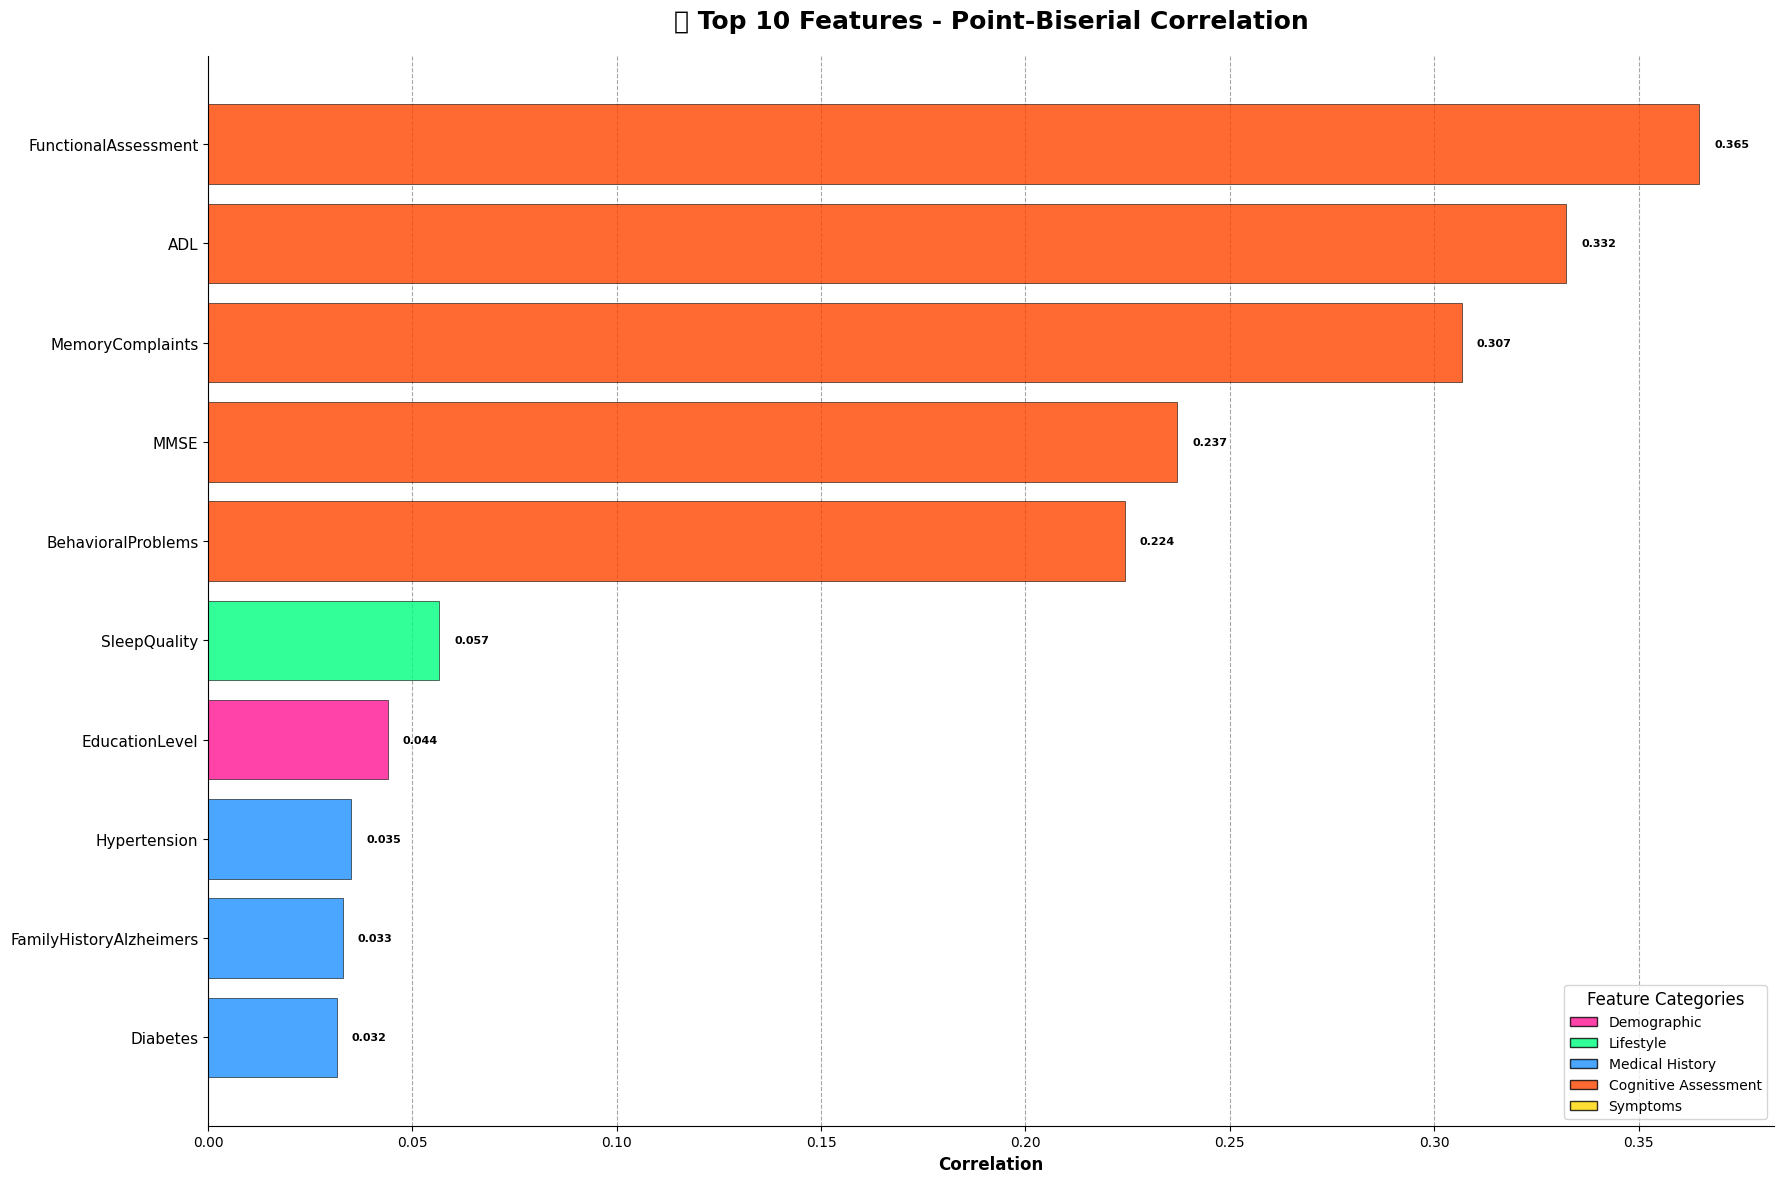

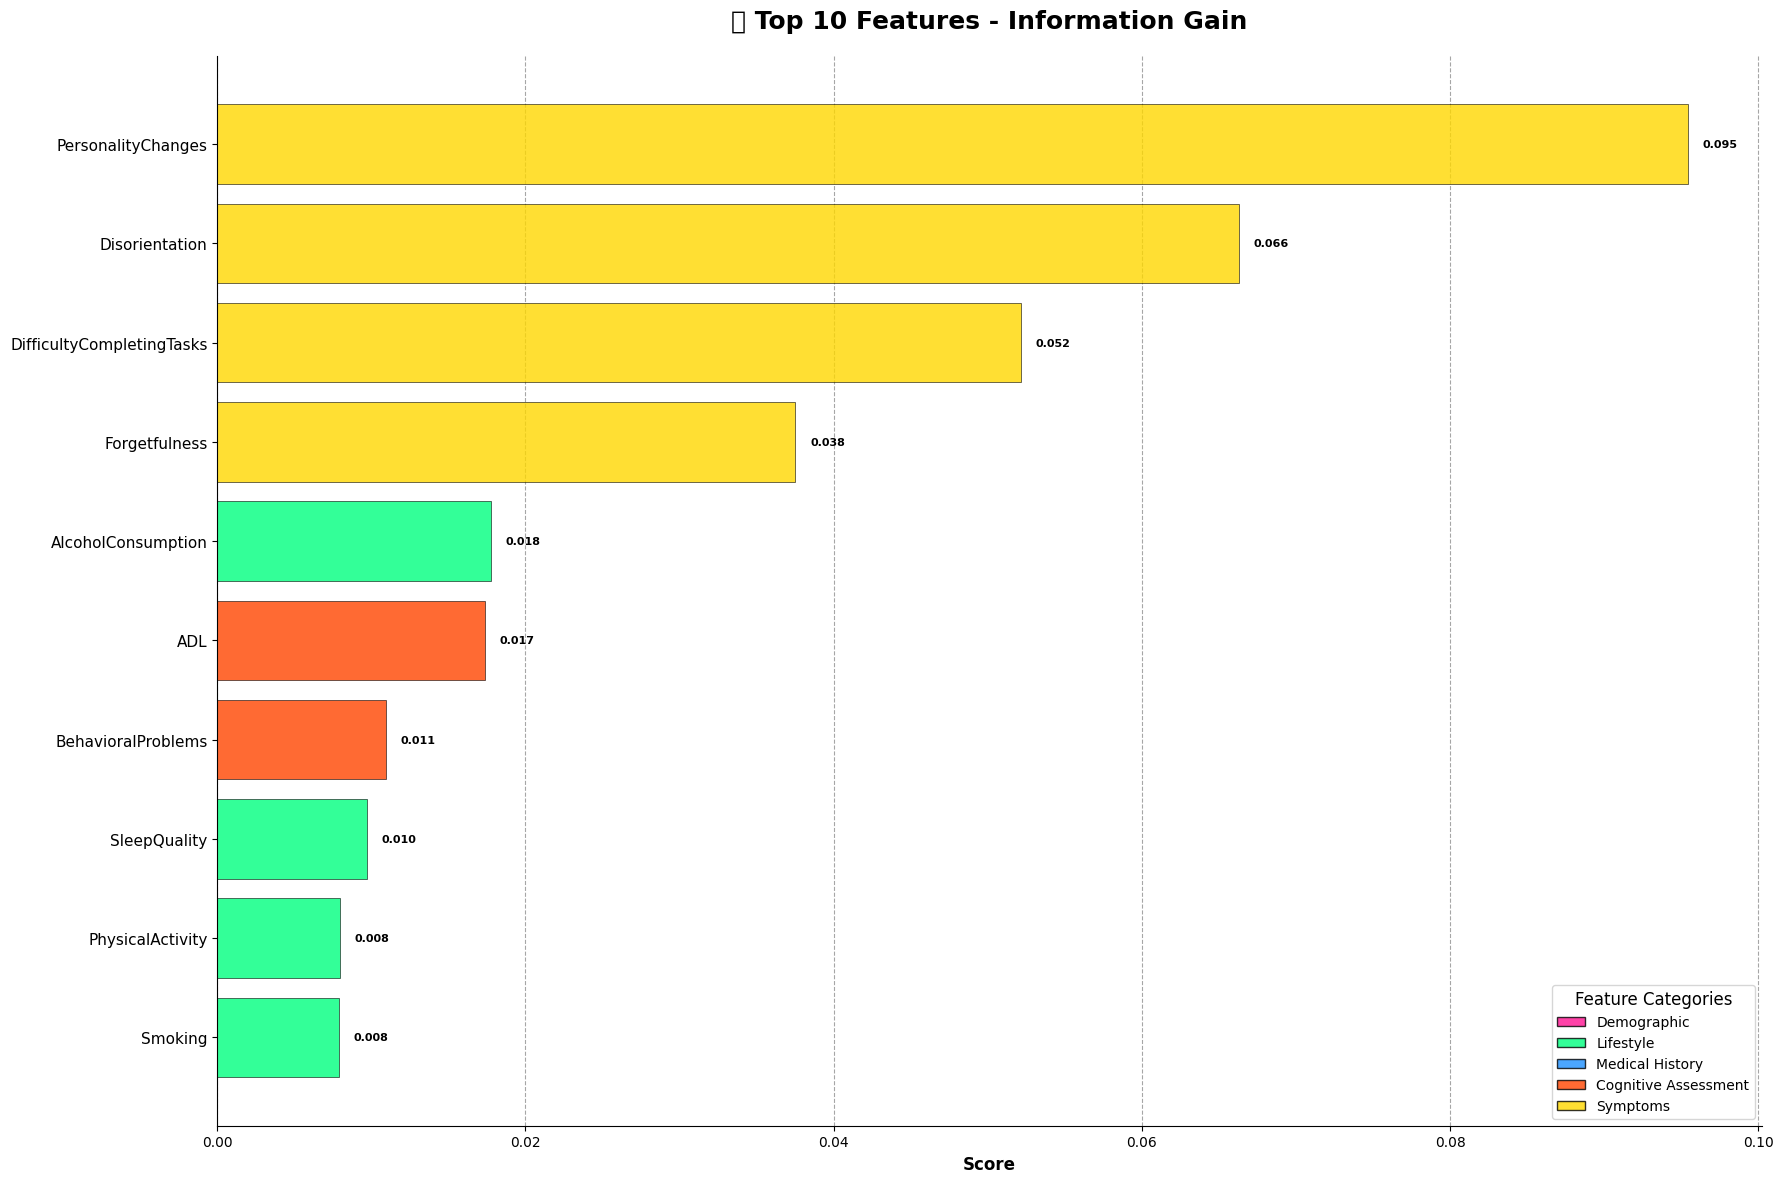

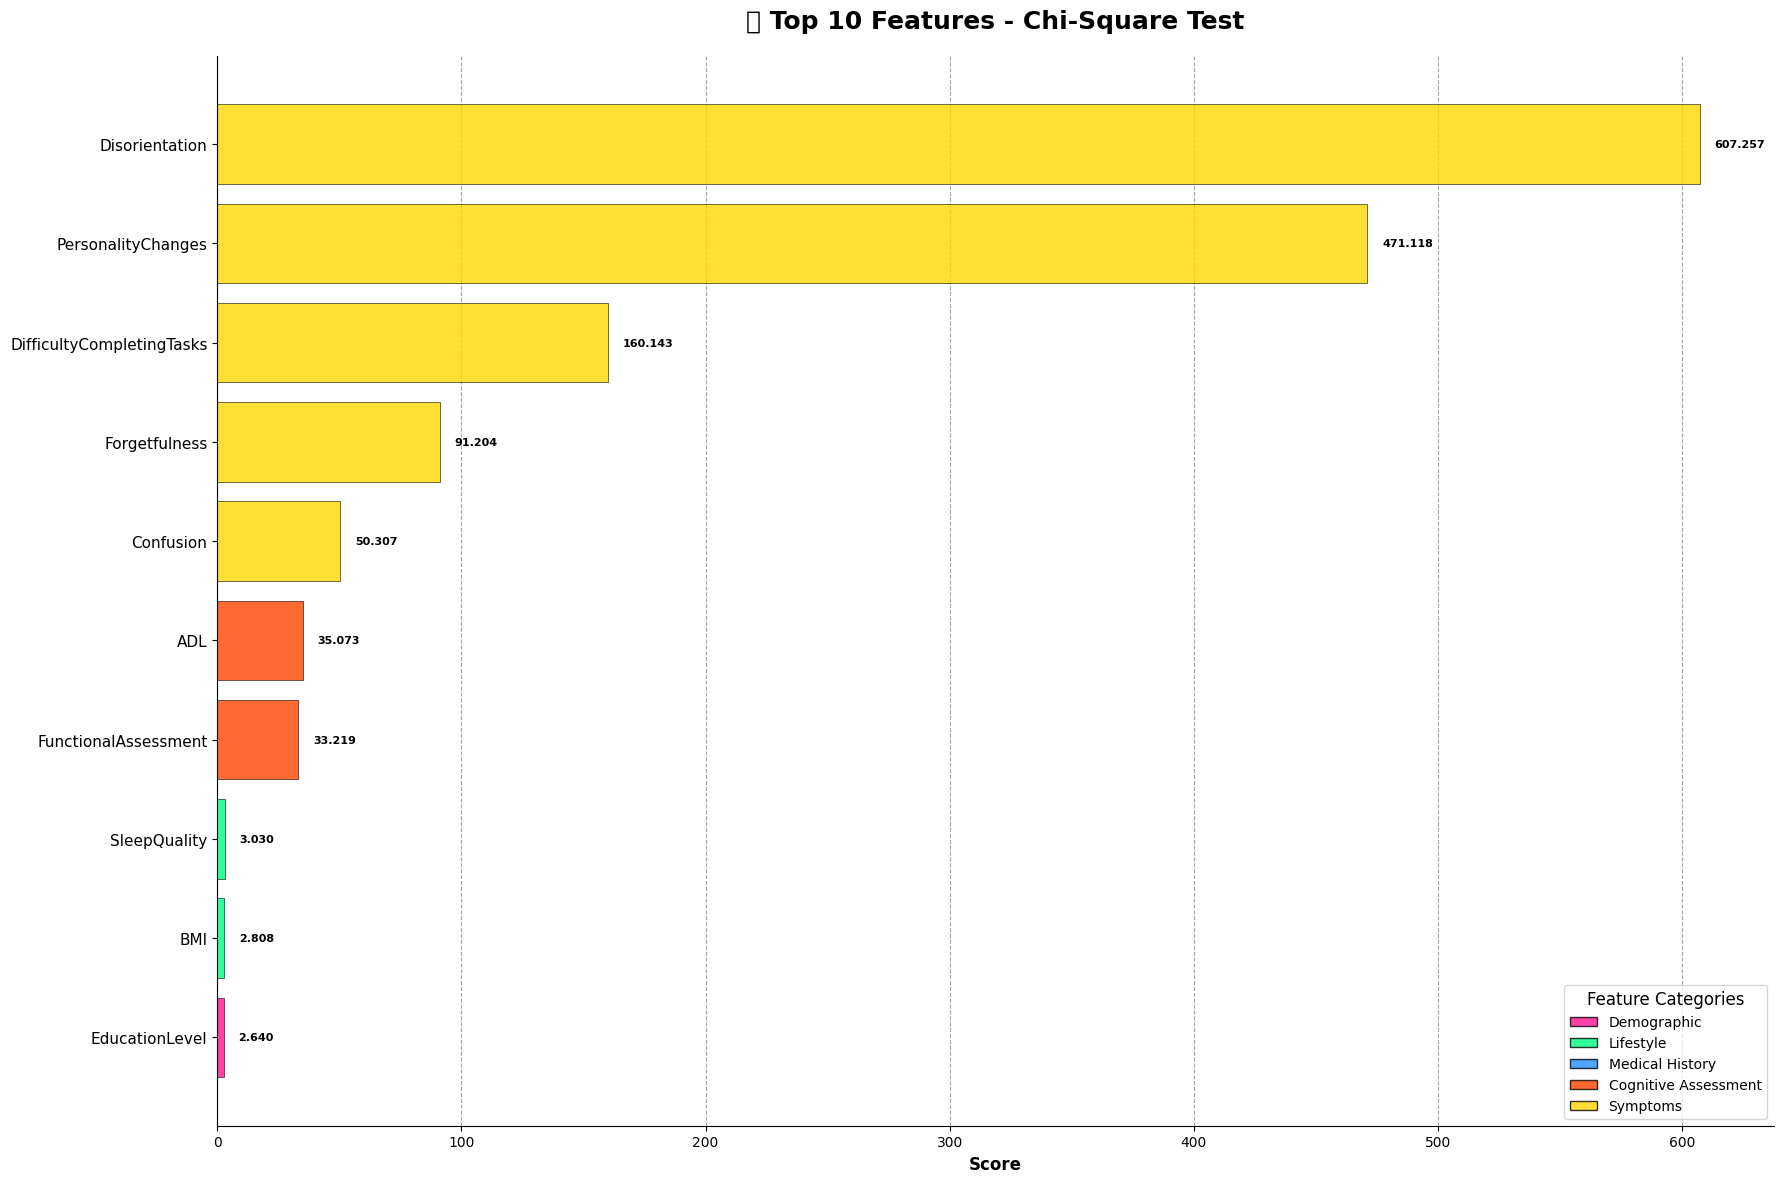

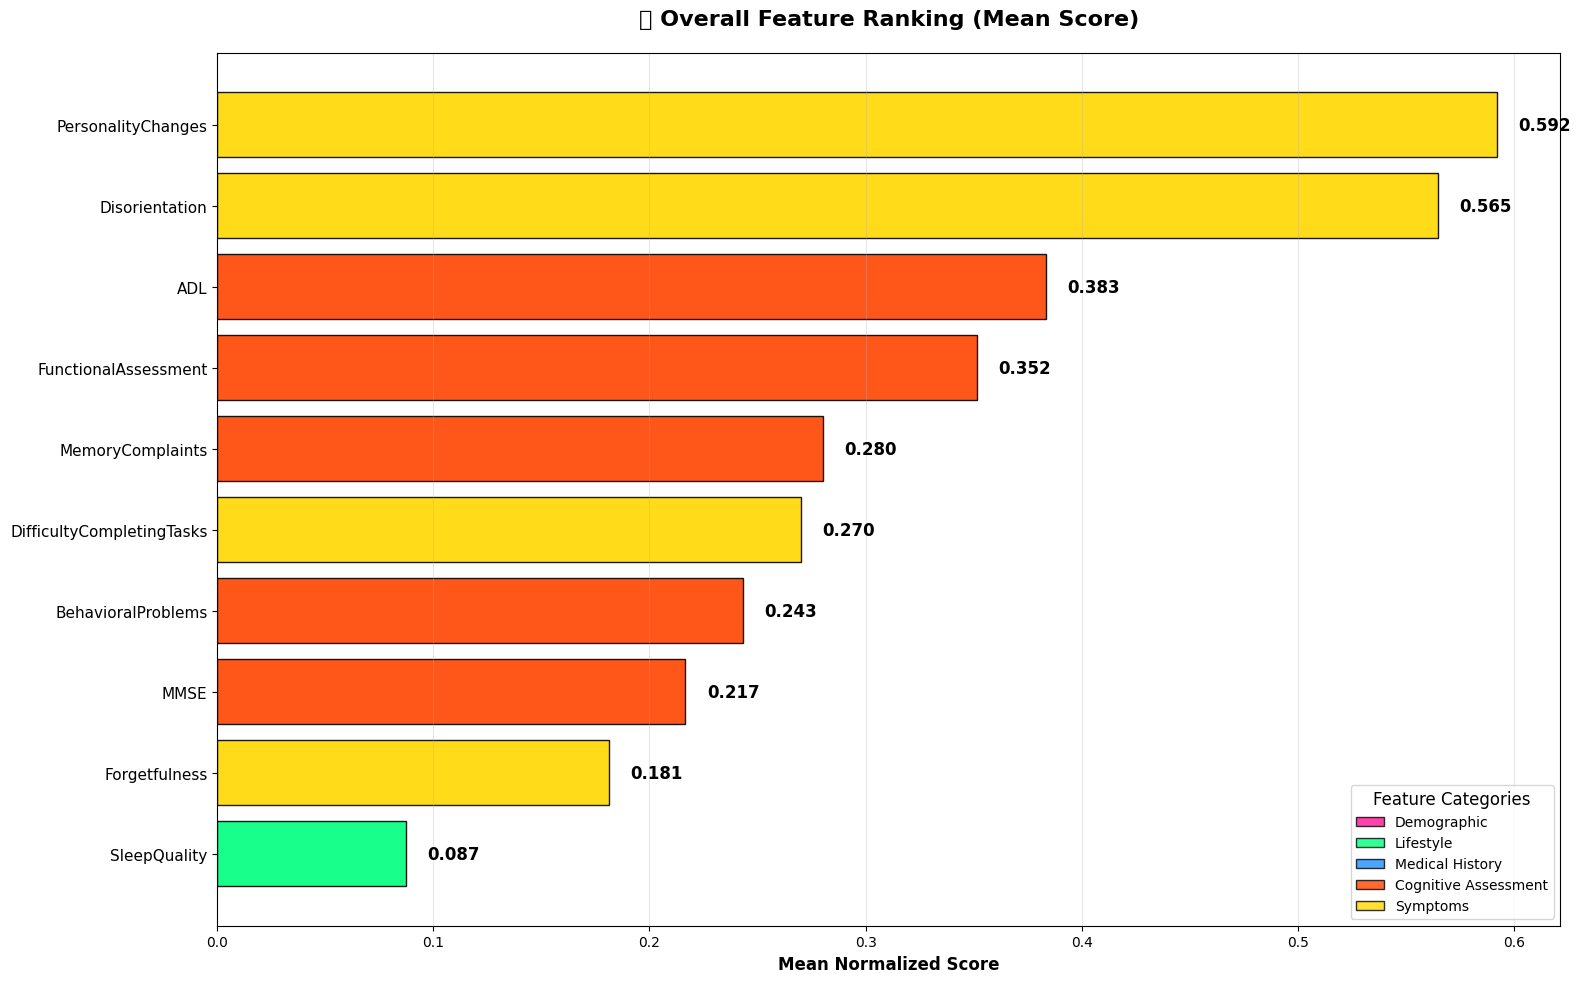

In [10]:
# 🔄 Load Dataset
# Load the Alzheimer's dataset from local path
data = pd.read_csv('/Users/swehavenkateshwari/Alzheimer/alzheimers_disease_data.csv')

# 🎯 Define Features & Target
X = data.drop(['PatientID', 'Diagnosis', 'DoctorInCharge'], axis=1)  # Feature matrix
y = data['Diagnosis']  # Target vector (binary diagnosis)

# 🧩 Define feature categories for structured analysis
demographic_features = ['Age', 'Gender','Ethnicity', 'EducationLevel']
lifestyle_features = ['BMI', 'Smoking', 'AlcoholConsumption', 'PhysicalActivity', 'DietQuality', 'SleepQuality']
medical_history = ['FamilyHistoryAlzheimers', 'CardiovascularDisease', 'Diabetes', 'Depression', 'HeadInjury', 'Hypertension']
cognitive_assessment = ['MemoryComplaints', 'BehavioralProblems','MMSE', 'FunctionalAssessment','ADL']
symptoms = ['Confusion', 'Disorientation', 'PersonalityChanges', 'DifficultyCompletingTasks', 'Forgetfulness']

# 🗂 Group features by category
feature_categories = {
    'Demographic': demographic_features,
    'Lifestyle': lifestyle_features,
    'Medical History': medical_history,
    'Cognitive Assessment': cognitive_assessment,
    'Symptoms': symptoms
}

# 🎨 Assign colors for visualization by feature category
category_colors = {
    'Demographic': '#FF1493',      # Deep Pink
    'Lifestyle': '#00FF7F',        # Spring Green
    'Medical History': '#1E90FF',  # Dodger Blue
    'Cognitive Assessment': '#FF4500', # Orange Red
    'Symptoms': '#FFD700'          # Gold
}

# 🛠 Utility to get all features across categories
def get_all_features():
    """Aggregate all features from all categories into a single list."""
    all_features = []
    for category in feature_categories.values():
        all_features.extend(category)
    return all_features

# 📊 Correlation Analysis
def correlation_analysis(X, y, feature_categories):
    """
    Compute point-biserial correlation between each feature and binary target.
    Returns correlation results and summary dataframe.
    """
    results = {}
    summary_data = []

    print("="*100)
    print("📊 POINT-BISERIAL CORRELATION ANALYSIS")
    print("="*100)

    for category, features in feature_categories.items():
        feature_corrs = []
        print(f"\n🔍 {category.upper()} FEATURES:")
        print("-" * 100)

        for feature in features:
            # Safely compute correlation, handle NaN or errors
            try:
                corr, p_value = pointbiserialr(X[feature].values, y.values)
                if np.isnan(corr):
                    corr, p_value = 0, 1
            except:
                corr, p_value = 0, 1

            # Determine significance
            if p_value < 0.001:
                significance = "***"
                sig_level = "Highly Significant"
            elif p_value < 0.01:
                significance = "**"
                sig_level = "Very Significant"
            elif p_value < 0.05:
                significance = "*"
                sig_level = "Significant"
            else:
                significance = ""
                sig_level = "Not Significant"

            feature_corrs.append({
                'Feature': feature,
                'Correlation': abs(corr),
                'P-value': p_value,
                'Significance': significance,
                'Category': category
            })

            summary_data.append({
                'Feature': feature,
                'Category': category,
                'Correlation': abs(corr),
                'P-value': p_value,
                'Significance Level': sig_level
            })

        # Sort features by correlation magnitude
        feature_corrs = sorted(feature_corrs, key=lambda x: x['Correlation'], reverse=True)
        results[category] = feature_corrs

        # Print progress bars for visualization
        for i, fc in enumerate(feature_corrs, 1):
            corr_val = fc['Correlation'] if not np.isnan(fc['Correlation']) else 0
            bar_length = max(0, min(40, int(corr_val * 40)))
            bar = "█" * bar_length + "░" * (40 - bar_length)
            print(f"{i:2d}. {fc['Feature']:<25} │ {bar} │ {corr_val:.4f} {fc['Significance']}")
            p_val = fc['P-value'] if not np.isnan(fc['P-value']) else 1.0
            print(f"    {'':25} │ p-value: {p_val:.4f}")

    # Overall summary table
    summary_df = pd.DataFrame(summary_data).sort_values('Correlation', ascending=False)
    print(f"\n{'='*100}")
    print("📈 TOP 10 FEATURES OVERALL - CORRELATION ANALYSIS")
    print("="*100)
    print(summary_df.head(10).to_string(index=False, float_format='%.4f'))

    # Compute overall correlation ranking
    all_corr = []
    for feature in get_all_features():
        try:
            corr, p_value = pointbiserialr(X[feature].values, y.values)
            if np.isnan(corr):
                corr, p_value = 0, 1
        except:
            corr, p_value = 0, 1

        all_corr.append({
            'Feature': feature,
            'Correlation': abs(corr),
            'P-value': p_value
        })
    results['Overall'] = sorted(all_corr, key=lambda x: x['Correlation'], reverse=True)

    return results, summary_df

# 🧠 Information Gain Analysis (Mutual Information)
def information_gain_analysis(X, y, feature_categories):
    """
    Compute mutual information scores between features and target.
    Returns results per category and summary dataframe.
    """
    results = {}
    summary_data = []

    print("\n" + "="*100)
    print("🧠 INFORMATION GAIN ANALYSIS (MUTUAL INFORMATION)")
    print("="*100)

    for category, features in feature_categories.items():
        print(f"\n🔍 {category.upper()} FEATURES:")
        print("-" * 100)

        X_category = X[features]
        selector = SelectKBest(mutual_info_classif, k='all')
        selector.fit(X_category, y)
        feature_scores = list(zip(features, selector.scores_))
        feature_scores = sorted(feature_scores, key=lambda x: x[1], reverse=True)
        results[category] = [{'Feature': f, 'Score': s} for f, s in feature_scores]

        # Print progress bars
        for i, (feature, score) in enumerate(feature_scores, 1):
            max_score = max([s for _, s in feature_scores])
            bar_length = max(0, min(40, int((score / max_score) * 40))) if max_score > 0 and not np.isnan(score) else 0
            bar = "█" * bar_length + "░" * (40 - bar_length)
            score_val = score if not np.isnan(score) else 0
            print(f"{i:2d}. {feature:<25} │ {bar} │ {score_val:.4f}")

            summary_data.append({
                'Feature': feature,
                'Category': category,
                'Info_Gain': score_val
            })

    # Overall scores
    selector = SelectKBest(mutual_info_classif, k='all')
    selector.fit(X, y)
    all_features = get_all_features()
    feature_scores = list(zip(all_features, selector.scores_))
    feature_scores = sorted(feature_scores, key=lambda x: x[1], reverse=True)
    results['Overall'] = [{'Feature': f, 'Score': s} for f, s in feature_scores]

    summary_df = pd.DataFrame(summary_data).sort_values('Info_Gain', ascending=False)
    print(f"\n{'='*100}")
    print("📈 TOP 10 FEATURES OVERALL - INFORMATION GAIN")
    print("="*100)
    print(summary_df.head(10).to_string(index=False, float_format='%.4f'))

    return results, summary_df

# 📏 Chi-Square Analysis
def chi_square_analysis(X, y, feature_categories):
    """
    Compute chi-square scores for categorical/non-negative features.
    Returns results per category and summary dataframe.
    """
    results = {}
    X_chi = X.copy()
    # Adjust negative values
    for col in X_chi.columns:
        if X_chi[col].min() < 0:
            X_chi[col] = X_chi[col] - X_chi[col].min()

    print("\n" + "="*100)
    print("📊 CHI-SQUARE ANALYSIS")
    print("="*100)

    summary_data = []

    for category, features in feature_categories.items():
        print(f"\n🔍 {category.upper()} FEATURES:")
        print("-" * 100)

        X_category = X_chi[features]
        selector = SelectKBest(chi2, k='all')
        selector.fit(X_category, y)
        feature_scores = list(zip(features, selector.scores_))
        feature_scores = sorted(feature_scores, key=lambda x: x[1], reverse=True)
        results[category] = [{'Feature': f, 'Score': s} for f, s in feature_scores]

        for i, (feature, score) in enumerate(feature_scores, 1):
            max_score = max([s for _, s in feature_scores])
            bar_length = max(0, min(40, int((score / max_score) * 40))) if max_score > 0 and not np.isnan(score) else 0
            bar = "█" * bar_length + "░" * (40 - bar_length)
            score_val = score if not np.isnan(score) else 0
            print(f"{i:2d}. {feature:<25} │ {bar} │ {score_val:.4f}")

            summary_data.append({
                'Feature': feature,
                'Category': category,
                'Chi_Square': score_val
            })

    # Overall chi-square scores
    selector = SelectKBest(chi2, k='all')
    selector.fit(X_chi, y)
    all_features = get_all_features()
    feature_scores = list(zip(all_features, selector.scores_))
    feature_scores = sorted(feature_scores, key=lambda x: x[1], reverse=True)
    results['Overall'] = [{'Feature': f, 'Score': s} for f, s in feature_scores]

    summary_df = pd.DataFrame(summary_data).sort_values('Chi_Square', ascending=False)
    print(f"\n{'='*100}")
    print("📈 TOP 10 FEATURES OVERALL - CHI-SQUARE")
    print("="*100)
    print(summary_df.head(10).to_string(index=False, float_format='%.4f'))

    return results, summary_df

# 📊 Visualization: Bar Chart for Single Method
def create_bar_chart(results, title, metric_name, top_n=10):
    """
    Generate horizontal bar chart for top features with color-coded categories.
    """
    fig, ax = plt.subplots(figsize=(18, 12))
    features = [item['Feature'] for item in results['Overall'][:top_n]]
    scores = [item[metric_name] for item in results['Overall'][:top_n]]

    # Map colors by category
    colors = []
    for feature in features:
        for cat, feats in feature_categories.items():
            if feature in feats:
                colors.append(category_colors[cat])
                break

    bars = ax.barh(range(len(features)), scores, color=colors, edgecolor='black', linewidth=0.5, alpha=0.8)
    ax.set_yticks(range(len(features)))
    ax.set_yticklabels(features, fontsize=11)
    ax.set_xlabel(f'{metric_name}', fontsize=12, fontweight='bold')
    ax.set_title(f'🏆 Top {top_n} Features - {title}', fontsize=18, fontweight='bold', pad=20)

    # Add numeric labels and grid
    for bar, score in zip(bars, scores):
        width = bar.get_width()
        score_val = score if not np.isnan(score) else 0
        max_score = max([s for s in scores if not np.isnan(s)]) if any(not np.isnan(s) for s in scores) else 1
        ax.text(width + max_score * 0.01, bar.get_y() + bar.get_height()/2, f'{score_val:.3f}', ha='left', va='center', fontweight='bold', fontsize=8)

    ax.grid(axis='x', linestyle='--', alpha=0.7, color='gray')
    ax.set_axisbelow(True)

    legend_elements = [mpatches.Patch(facecolor=color, edgecolor='black', label=category, alpha=0.8)
                      for category, color in category_colors.items()]
    ax.legend(handles=legend_elements, loc='lower right', fontsize=10, title='Feature Categories', title_fontsize=12)

    ax.invert_yaxis()  # Display highest values on top
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.tight_layout()
    plt.show()

# 🏆 Combined Feature Ranking Across Methods
def create_mean_score_chart(correlation_results, info_gain_results, chi_square_results, top_n=10):
    """
    Generate mean score ranking across correlation, information gain, and chi-square.
    """
    # Extract top features from each method
    corr_top = [(item['Feature'], item['Correlation']) for item in correlation_results['Overall'][:top_n]]
    info_top = [(item['Feature'], item['Score']) for item in info_gain_results['Overall'][:top_n]]
    chi_top = [(item['Feature'], item['Score']) for item in chi_square_results['Overall'][:top_n]]

    all_features = list(set([f for f, _ in corr_top + info_top + chi_top]))  # Unique top features
    comparison_df = pd.DataFrame(index=all_features)

    # Normalize scores
    corr_max = max([s for _, s in corr_top]) if corr_top else 1
    info_max = max([s for _, s in info_top]) if info_top else 1
    chi_max = max([s for _, s in chi_top]) if chi_top else 1

    corr_dict = {f: (s/corr_max if corr_max > 0 and not np.isnan(s) else 0) for f, s in corr_top}
    info_dict = {f: (s/info_max if info_max > 0 and not np.isnan(s) else 0) for f, s in info_top}
    chi_dict = {f: (s/chi_max if chi_max > 0 and not np.isnan(s) else 0) for f, s in chi_top}

    comparison_df['Correlation'] = [corr_dict.get(f, 0) for f in all_features]
    comparison_df['Information_Gain'] = [info_dict.get(f, 0) for f in all_features]
    comparison_df['Chi_Square'] = [chi_dict.get(f, 0) for f in all_features]
    comparison_df = comparison_df.fillna(0)
    comparison_df['Mean_Score'] = comparison_df.mean(axis=1)
    comparison_df = comparison_df.sort_values('Mean_Score', ascending=False).head(top_n)

    # Plot
    fig, ax = plt.subplots(figsize=(16, 10))
    colors_mean = [category_colors[cat] for feature in comparison_df.index for cat, feats in feature_categories.items() if feature in feats]
    bars_mean = ax.barh(range(len(comparison_df)), comparison_df['Mean_Score'], color=colors_mean, alpha=0.9, edgecolor='black', linewidth=1)
    ax.set_yticks(range(len(comparison_df)))
    ax.set_yticklabels(comparison_df.index, fontsize=11)
    ax.set_xlabel('Mean Normalized Score', fontweight='bold', fontsize=12)
    ax.set_title('🏆 Overall Feature Ranking (Mean Score)', fontweight='bold', fontsize=16, pad=20)

    legend_elements = [mpatches.Patch(facecolor=color, edgecolor='black', label=category, alpha=0.8)
                      for category, color in category_colors.items()]
    ax.legend(handles=legend_elements, loc='lower right', fontsize=10, title='Feature Categories', title_fontsize=12)
    ax.invert_yaxis()
    ax.grid(axis='x', alpha=0.3)

    # Add score labels
    for i, bar in enumerate(bars_mean):
        width_val = bar.get_width() if not np.isnan(bar.get_width()) else 0
        ax.text(width_val + 0.01, bar.get_y() + bar.get_height()/2, f'{width_val:.3f}', ha='left', va='center', fontweight='bold')

    plt.tight_layout()
    plt.show()

    return comparison_df

# ✅ Perform Analyses
correlation_results, corr_summary = correlation_analysis(X, y, feature_categories)
info_gain_results, info_summary = information_gain_analysis(X, y, feature_categories)
chi_square_results, chi_summary = chi_square_analysis(X, y, feature_categories)

# 📊 Visualize Each Method's Top Features
create_bar_chart(correlation_results, 'Point-Biserial Correlation', 'Correlation')
create_bar_chart(info_gain_results, 'Information Gain', 'Score')
create_bar_chart(chi_square_results, 'Chi-Square Test', 'Score')

# 🏆 Combined Feature Ranking and Visualization
comparison_df = create_mean_score_chart(correlation_results, info_gain_results, chi_square_results, top_n=10)


In [11]:
def get_top_features_for_modeling(comparison_df, top_n=10):
    """
    🎯 Select top N features for machine learning modeling based on combined mean scores.

    Parameters:
        comparison_df (pd.DataFrame): DataFrame containing normalized scores for all features
                                      across correlation, information gain, and chi-square analyses.
                                      Must include a 'Mean_Score' column.
        top_n (int): Number of top features to select for modeling.

    Returns:
        list: List of top feature names to use as predictors in ML models.
    """
    # Extract top N features by Mean_Score
    top_features = comparison_df.head(top_n).index.tolist()

    # Display selected features with category and score
    print(f"\n🎯 Top {top_n} Features Selected for Modeling:")
    print("-" * 50)
    for i, feature in enumerate(top_features, 1):
        score = comparison_df.loc[feature, 'Mean_Score']
        # Determine feature category from predefined mapping
        category = next(cat for cat, feats in feature_categories.items() if feature in feats)
        print(f"{i:2d}. {feature:<25} │ {category:<20} │ Score: {score:.4f}")

    # Return the list of feature names for downstream modeling
    return top_features

# ✅ Example usage: select top 10 features
top_10_features = get_top_features_for_modeling(comparison_df, top_n=10)



🎯 Top 10 Features Selected for Modeling:
--------------------------------------------------
 1. PersonalityChanges        │ Symptoms             │ Score: 0.5919
 2. Disorientation            │ Symptoms             │ Score: 0.5648
 3. ADL                       │ Cognitive Assessment │ Score: 0.3834
 4. FunctionalAssessment      │ Cognitive Assessment │ Score: 0.3516
 5. MemoryComplaints          │ Cognitive Assessment │ Score: 0.2802
 6. DifficultyCompletingTasks │ Symptoms             │ Score: 0.2700
 7. BehavioralProblems        │ Cognitive Assessment │ Score: 0.2432
 8. MMSE                      │ Cognitive Assessment │ Score: 0.2166
 9. Forgetfulness             │ Symptoms             │ Score: 0.1811
10. SleepQuality              │ Lifestyle            │ Score: 0.0872


In [12]:
# -----------------------------------------
# Data Preprocessing, Modeling, and Evaluation
# -----------------------------------------

# 1️⃣ Identify categorical and numerical columns
categorical_cols = [
    'Gender', 'Ethnicity', 'Smoking', 'AlcoholConsumption', 'FamilyHistoryAlzheimers',
    'CardiovascularDisease', 'Diabetes', 'Depression', 'HeadInjury', 'Hypertension',
    'MemoryComplaints', 'BehavioralProblems', 'Confusion', 'Disorientation',
    'PersonalityChanges', 'DifficultyCompletingTasks', 'Forgetfulness'
]

numerical_cols = [col for col in X.columns if col not in categorical_cols]

# 2️⃣ Create preprocessing pipelines

# Numerical pipeline: fill missing values using KNNImputer and scale features
numerical_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', StandardScaler())
])

# Categorical pipeline: fill missing values with the most frequent value
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

# Combine numerical and categorical pipelines
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ],
    remainder='passthrough'
)

# 3️⃣ Select top 10 features for modeling (from feature ranking)
X_top = X[top_10_features]

# 4️⃣ Split data into training and test sets (80/20), stratified by target
X_train_top, X_test_top, y_train_top, y_test_top = train_test_split(
    X_top, y, test_size=0.2, random_state=42, stratify=y
)

# Optional: track patient IDs for test set
if 'PatientID' in data.columns:
    test_patient_ids = data.loc[X_test_top.index, 'PatientID']
    test_data_with_ids = data.loc[X_test_top.index].copy()
    print(f"Test set Patient ID range: {test_patient_ids.min()} to {test_patient_ids.max()}")
    print(f"Number of test patients: {len(test_patient_ids)}")
else:
    print("Warning: No PatientID column found in original DataFrame")
    test_data_with_ids = None

# 5️⃣ Further split training data into training and validation sets (75/25), stratified
X_train_top, X_val_top, y_train_top, y_val_top = train_test_split(
    X_train_top, y_train_top, test_size=0.25, random_state=42, stratify=y_train_top
)

# Identify categorical and numerical columns among top features
categorical_top = [col for col in top_10_features if col in categorical_cols]
numerical_top = [col for col in top_10_features if col in numerical_cols]

# Preprocessor for only top features
preprocessor_top = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_top),
        ('cat', categorical_transformer, categorical_top)
    ],
    remainder='passthrough'
)

# Fit and transform training, validation, and test sets
X_train_top_preprocessed = preprocessor_top.fit_transform(X_train_top)
X_val_top_preprocessed = preprocessor_top.transform(X_val_top)
X_test_top_preprocessed = preprocessor_top.transform(X_test_top)

# 6️⃣ Handle class imbalance using SMOTETomek
smote_tomek_top = SMOTETomek(random_state=42)
X_train_top_balanced, y_train_top_balanced = smote_tomek_top.fit_resample(
    X_train_top_preprocessed, y_train_top
)

print(f"\nOriginal training dataset shape: {np.bincount(y_train_top)}")
print(f"Balanced training dataset shape: {np.bincount(y_train_top_balanced)}")

# -------------------------
# 7️⃣ Define models and hyperparameters
# -------------------------

models = {
    'DecisionTree': DecisionTreeClassifier(random_state=42),
    'SVM': SVC(probability=True, kernel='rbf', C=1.0, gamma='scale', random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42, n_estimators=200, class_weight='balanced'),
    'XGBoost': XGBClassifier(random_state=42, n_estimators=200, learning_rate=0.1,
                             use_label_encoder=False, eval_metric='logloss'),
    'CatBoost': CatBoostClassifier(random_state=42, verbose=0)
}

param_grids = {
    'DecisionTree': {'max_depth': [None, 10, 20, 30], 'min_samples_split': [2,5,10], 'min_samples_leaf':[1,2,4]},
    'SVM': {'C': [0.1,1,10], 'kernel': ['linear','rbf']},
    'RandomForest': {'n_estimators':[180], 'max_depth':[3]},
    'XGBoost': {'learning_rate':[0.1], 'n_estimators':[180], 'max_depth':[3]},
    'CatBoost': {'learning_rate':[0.01], 'iterations':[180], 'depth':[5]}
}

# Containers for storing results
model_performance = {}
best_models = {}

print("="*80)
print("🚀 TRAINING INDIVIDUAL MODELS")
print("="*80)

# 8️⃣ Train each model using GridSearchCV
for name, model in models.items():
    print(f"\n📊 Training {name}...")

    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grids[name],
        scoring='roc_auc',
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        n_jobs=-1,
        verbose=1
    )

    grid_search.fit(X_train_top_balanced, y_train_top_balanced)
    best_model = grid_search.best_estimator_
    best_models[name] = best_model

    # Validation predictions
    y_val_pred = best_model.predict(X_val_top_preprocessed)

    if hasattr(best_model, 'predict_proba'):
        y_val_proba = best_model.predict_proba(X_val_top_preprocessed)[:,1]
        roc_auc = roc_auc_score(y_val_top, y_val_proba)
        avg_precision = average_precision_score(y_val_top, y_val_proba)
    else:
        y_val_proba = None
        roc_auc = np.nan
        avg_precision = np.nan

    accuracy = accuracy_score(y_val_top, y_val_pred)

    model_performance[name] = {
        'accuracy': accuracy,
        'roc_auc': roc_auc,
        'avg_precision': avg_precision,
        'best_params': grid_search.best_params_
    }

    print(f"\n✅ {name} Validation Results:")
    print(f"Accuracy: {accuracy:.4f}")
    if not np.isnan(roc_auc):
        print(f"ROC AUC: {roc_auc:.4f}, Avg Precision: {avg_precision:.4f}")
    else:
        print("Probability metrics not available for this model type.")
    print(f"Best Parameters: {grid_search.best_params_}")

# -------------------------
# 9️⃣ Create Voting Classifiers
# -------------------------

print("="*80)
print("🗳️  CREATING VOTING CLASSIFIERS")
print("="*80)

hard_voting_clf = VotingClassifier(
    estimators=[('dt', best_models['DecisionTree']),
                #('svm', best_models['SVM']),
                ('rf', best_models['RandomForest']),
                ('xgb', best_models['XGBoost']),
                ('cat', best_models['CatBoost'])],
    voting='hard'
)

soft_voting_clf = VotingClassifier(
    estimators=[('dt', best_models['DecisionTree']),
                ('svm', best_models['SVM']),
                ('rf', best_models['RandomForest']),
                ('xgb', best_models['XGBoost']),
                ('cat', best_models['CatBoost'])],
    voting='soft'
)

print("📊 Training Soft Voting Classifier...")
soft_voting_clf.fit(X_train_top_balanced, y_train_top_balanced)

y_val_pred_soft = soft_voting_clf.predict(X_val_top_preprocessed)
y_val_proba_soft = soft_voting_clf.predict_proba(X_val_top_preprocessed)[:,1]

accuracy_soft = accuracy_score(y_val_top, y_val_pred_soft)
roc_auc_soft = roc_auc_score(y_val_top, y_val_proba_soft)
avg_precision_soft = average_precision_score(y_val_top, y_val_proba_soft)

voting_results = {
    'Soft_Voting': {'accuracy': accuracy_soft, 'roc_auc': roc_auc_soft,
                    'avg_precision': avg_precision_soft, 'model': soft_voting_clf}
}

print(f"\n✅ Soft Voting Validation Results:")
print(f"Accuracy: {accuracy_soft:.4f}, ROC AUC: {roc_auc_soft:.4f}, Avg Precision: {avg_precision_soft:.4f}")

model_performance.update(voting_results)

# -------------------------
# 1️⃣0️⃣ Model Comparison and Selection
# -------------------------

print("="*80)
print("📊 COMPREHENSIVE MODEL COMPARISON")
print("="*80)

sorted_models = sorted(
    model_performance.items(),
    key=lambda x: x[1]['roc_auc'] if not np.isnan(x[1]['roc_auc']) else -1,
    reverse=True
)

print(f"\n🏆 MODEL RANKING (by ROC AUC):")
print("-"*70)
print(f"{'Rank':<4} {'Model':<20} {'Accuracy':<10} {'ROC AUC':<10} {'Avg Precision':<15}")
print("-"*70)
for i, (name, metrics) in enumerate(sorted_models,1):
    roc_auc_display = f"{metrics['roc_auc']:.4f}" if not np.isnan(metrics['roc_auc']) else "N/A"
    avg_precision_display = f"{metrics['avg_precision']:.4f}" if not np.isnan(metrics['avg_precision']) else "N/A"
    print(f"{i:<4} {name:<20} {metrics['accuracy']:.4f}     {roc_auc_display:<10}     {avg_precision_display:<15}")

best_model_name = sorted_models[0][0]
best_model_metrics = sorted_models[0][1]
best_model = best_model_metrics.get('model', best_models.get(best_model_name))

print(f"\n🥇 Best Model: {best_model_name}, ROC AUC: {best_model_metrics['roc_auc']:.4f}")

# -------------------------
# 1️⃣1️⃣ Final Test Set Evaluation
# -------------------------

print("="*80)
print("🔬 FINAL TEST SET EVALUATION")
print("="*80)

y_test_pred = best_model.predict(X_test_top_preprocessed)

if hasattr(best_model, 'predict_proba'):
    y_test_proba = best_model.predict_proba(X_test_top_preprocessed)[:,1]
    test_roc_auc = roc_auc_score(y_test_top, y_test_proba)
    test_avg_precision = average_precision_score(y_test_top, y_test_proba)
else:
    y_test_proba = None
    test_roc_auc = np.nan
    test_avg_precision = np.nan

test_accuracy = accuracy_score(y_test_top, y_test_pred)

print(f"\n🎯 {best_model_name} - Test Results:")
print(f"Accuracy: {test_accuracy:.4f}")
if not np.isnan(test_roc_auc):
    print(f"ROC AUC: {test_roc_auc:.4f}, Avg Precision: {test_avg_precision:.4f}")
else:
    print("Probability metrics not available for this model type.")

print("\nClassification Report:")
print(classification_report(y_test_top, y_test_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test_top, y_test_pred))


Test set Patient ID range: 4752 to 6891
Number of test patients: 430

Original training dataset shape: [833 456]
Balanced training dataset shape: [809 809]
🚀 TRAINING INDIVIDUAL MODELS

📊 Training DecisionTree...
Fitting 5 folds for each of 36 candidates, totalling 180 fits

✅ DecisionTree Validation Results:
Accuracy: 0.9302
ROC AUC: 0.9427, Avg Precision: 0.8837
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10}

📊 Training SVM...
Fitting 5 folds for each of 6 candidates, totalling 30 fits

✅ SVM Validation Results:
Accuracy: 0.9047
ROC AUC: 0.9374, Avg Precision: 0.9202
Best Parameters: {'C': 10, 'kernel': 'rbf'}

📊 Training RandomForest...
Fitting 5 folds for each of 1 candidates, totalling 5 fits

✅ RandomForest Validation Results:
Accuracy: 0.9419
ROC AUC: 0.9532, Avg Precision: 0.9454
Best Parameters: {'max_depth': 3, 'n_estimators': 180}

📊 Training XGBoost...
Fitting 5 folds for each of 1 candidates, totalling 5 fits

✅ XGBoost Validation Result

/opt/miniconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:00:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/miniconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:00:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/miniconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:00:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/miniconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:00:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iterati


✅ CatBoost Validation Results:
Accuracy: 0.9512
ROC AUC: 0.9611, Avg Precision: 0.9505
Best Parameters: {'depth': 5, 'iterations': 180, 'learning_rate': 0.01}
🗳️  CREATING VOTING CLASSIFIERS
📊 Training Soft Voting Classifier...

✅ Soft Voting Validation Results:
Accuracy: 0.9488, ROC AUC: 0.9567, Avg Precision: 0.9427
📊 COMPREHENSIVE MODEL COMPARISON

🏆 MODEL RANKING (by ROC AUC):
----------------------------------------------------------------------
Rank Model                Accuracy   ROC AUC    Avg Precision  
----------------------------------------------------------------------
1    CatBoost             0.9512     0.9611         0.9505         
2    Soft_Voting          0.9488     0.9567         0.9427         
3    RandomForest         0.9419     0.9532         0.9454         
4    XGBoost              0.9512     0.9525         0.9345         
5    DecisionTree         0.9302     0.9427         0.8837         
6    SVM                  0.9047     0.9374         0.9202         




📊 GENERATING ENHANCED VISUALIZATIONS
Getting training and validation predictions for CatBoost...
Training Metrics - Accuracy: 95.43%, ROC AUC: 97.41%, Avg Precision: 97.33%
Validation Metrics - Accuracy: 95.12%, ROC AUC: 96.11%, Avg Precision: 95.05%
Test Metrics - Accuracy: 94.65%, ROC AUC: 94.07%, Avg Precision: 91.34%


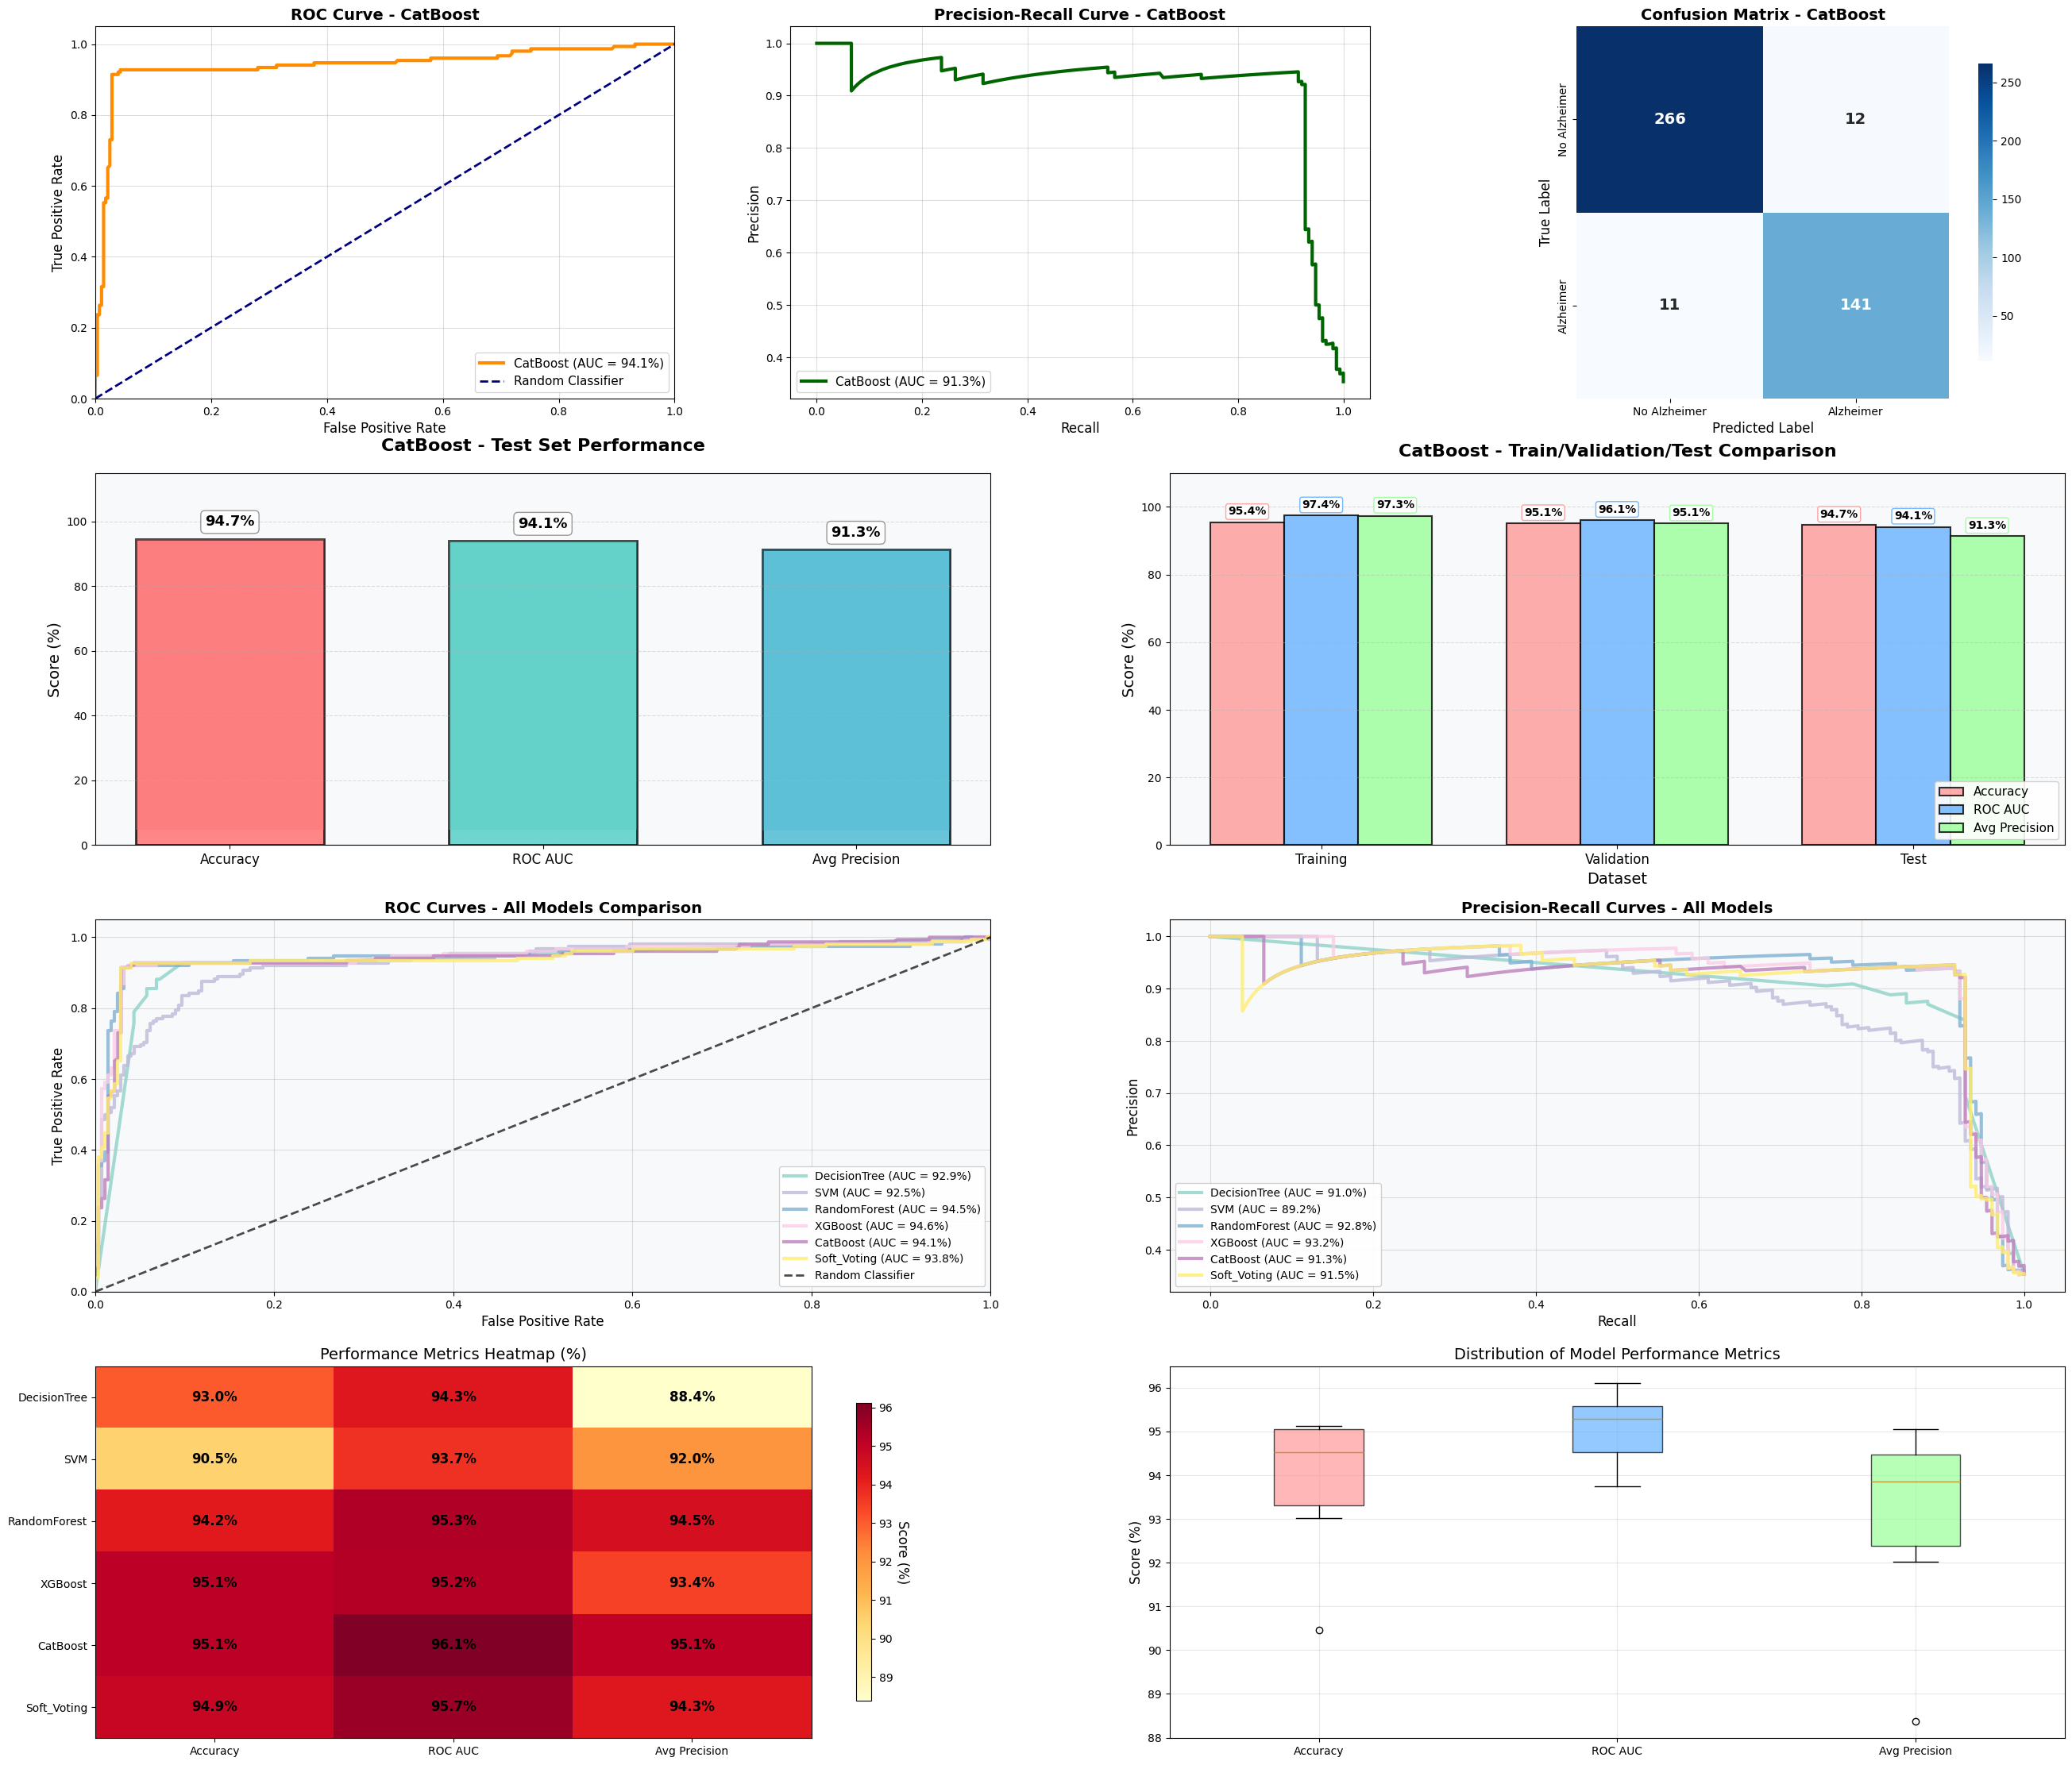

In [13]:
print("\n" + "="*80)
print("📊 GENERATING ENHANCED VISUALIZATIONS")
print("="*80)

# Set the plotting style and aesthetics for all plots
plt.style.use('default')  # Reset to default matplotlib style
sns.set_palette("husl")   # Use seaborn's Husl color palette for vibrant colors

# Update matplotlib rcParams to customize fonts and sizes for better readability
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.titlesize': 16
})

# Inform the user which model's predictions we are using
print(f"Getting training and validation predictions for {best_model_name}...")

# ---------------------------
# Predict on training data
# ---------------------------
y_train_pred = best_model.predict(X_train_top_balanced)

# For models that support probabilities, calculate training ROC AUC and Average Precision
if hasattr(best_model, 'predict_proba'):
    y_train_proba = best_model.predict_proba(X_train_top_balanced)[:, 1]
    train_roc_auc = roc_auc_score(y_train_top_balanced, y_train_proba)
    train_avg_precision = average_precision_score(y_train_top_balanced, y_train_proba)
else:
    # If probabilities are not supported, set these metrics to NaN
    train_roc_auc = np.nan
    train_avg_precision = np.nan

# Calculate training accuracy
train_accuracy = accuracy_score(y_train_top_balanced, y_train_pred)

# Retrieve validation set metrics from earlier calculations
val_accuracy = best_model_metrics['accuracy']
val_roc_auc = best_model_metrics['roc_auc']
val_avg_precision = best_model_metrics['avg_precision']

# Print out metrics for training, validation, and test datasets (as percentages)
print(f"Training Metrics - Accuracy: {train_accuracy*100:.2f}%, ROC AUC: {train_roc_auc*100:.2f}%, Avg Precision: {train_avg_precision*100:.2f}%")
print(f"Validation Metrics - Accuracy: {val_accuracy*100:.2f}%, ROC AUC: {val_roc_auc*100:.2f}%, Avg Precision: {val_avg_precision*100:.2f}%")
print(f"Test Metrics - Accuracy: {test_accuracy*100:.2f}%, ROC AUC: {test_roc_auc*100:.2f}%, Avg Precision: {test_avg_precision*100:.2f}%")

# ---------------------------
# Create main figure and subplots
# ---------------------------
fig = plt.figure(figsize=(32, 28))  # Large figure size for detailed plots

# ---------- ROW 1: ROC Curve, Precision-Recall Curve, Confusion Matrix ----------

# 1. ROC Curve for the best model on test set
ax1 = plt.subplot(4, 3, 1)  # 4 rows, 3 cols, position 1
if hasattr(best_model, 'predict_proba') and y_test_proba is not None:
    fpr, tpr, _ = roc_curve(y_test_top, y_test_proba)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve line and baseline
    plt.plot(fpr, tpr, color='darkorange', lw=3,
             label=f'{best_model_name} (AUC = {roc_auc*100:.1f}%)')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')

    # Axis labels and limits
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)

    # Title and legend
    plt.title(f'ROC Curve - {best_model_name}', fontsize=14, fontweight='bold')
    plt.legend(loc="lower right", fontsize=11)
    plt.grid(alpha=0.4)
else:
    # Inform user if ROC curve can't be drawn (e.g., no predict_proba)
    plt.text(0.5, 0.5, 'ROC Curve not available\nfor this model type',
             ha='center', va='center', transform=ax1.transAxes, fontsize=14)
    plt.title(f'ROC Curve - {best_model_name}', fontsize=14, fontweight='bold')

# 2. Precision-Recall Curve for the best model on test set
ax2 = plt.subplot(4, 3, 2)
if hasattr(best_model, 'predict_proba') and y_test_proba is not None:
    precision, recall, _ = precision_recall_curve(y_test_top, y_test_proba)
    pr_auc = auc(recall, precision)

    # Plot PR curve line
    plt.plot(recall, precision, color='darkgreen', lw=3,
             label=f'{best_model_name} (AUC = {pr_auc*100:.1f}%)')
    plt.xlabel('Recall', fontsize=12)
    plt.ylabel('Precision', fontsize=12)
    plt.title(f'Precision-Recall Curve - {best_model_name}', fontsize=14, fontweight='bold')
    plt.legend(loc="lower left", fontsize=11)
    plt.grid(alpha=0.4)
else:
    plt.text(0.5, 0.5, 'PR Curve not available\nfor this model type',
             ha='center', va='center', transform=ax2.transAxes, fontsize=14)
    plt.title(f'Precision-Recall Curve - {best_model_name}', fontsize=14, fontweight='bold')

# 3. Confusion Matrix Heatmap for best model predictions on test set
ax3 = plt.subplot(4, 3, 3)
cm = confusion_matrix(y_test_top, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', square=True,
            xticklabels=['No Alzheimer', 'Alzheimer'],
            yticklabels=['No Alzheimer', 'Alzheimer'],
            annot_kws={'size': 14, 'weight': 'bold'},
            cbar_kws={'shrink': 0.8})
plt.title(f'Confusion Matrix - {best_model_name}', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)

# ---------- ROW 2: Bar Charts comparing model metrics ----------

# Prepare data for bar charts:
valid_models = {name: metrics for name, metrics in model_performance.items()
                if not np.isnan(metrics['roc_auc'])}
model_names = list(valid_models.keys())
roc_scores = [metrics['roc_auc'] for metrics in valid_models.values()]
accuracy_scores = [metrics['accuracy'] for metrics in model_performance.values()]
all_model_names = list(model_performance.keys())

# 4. Bar chart for best model's test set metrics (accuracy, ROC AUC, avg precision) - as percentages
ax4 = plt.subplot(4, 2, 3)
if not np.isnan(test_roc_auc) and not np.isnan(test_avg_precision):
    metrics = ['Accuracy', 'ROC AUC', 'Avg Precision']
    scores = [test_accuracy*100, test_roc_auc*100, test_avg_precision*100]  # Convert to percentages
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

    # Draw bars with color, transparency, and edges
    bars = plt.bar(metrics, scores, color=colors, alpha=0.8,
                   edgecolor='black', linewidth=2, width=0.6)

    # Add gradient effect by overlaying transparent lighter bars
    for i, (bar, color) in enumerate(zip(bars, colors)):
        lighter_color = plt.matplotlib.colors.to_rgba(color, alpha=0.3)
        plt.bar(metrics[i], scores[i] * 0.95, color=lighter_color,
                edgecolor='none', width=0.6, bottom=scores[i] * 0.05)

    plt.ylim(0, 115)  # Adjust y-limit for percentage scale
    plt.title(f'{best_model_name} - Test Set Performance',
              fontsize=16, fontweight='bold', pad=20)
    plt.ylabel('Score (%)', fontsize=14)

    # Add value labels above bars with white backgrounds for clarity
    for bar, score in zip(bars, scores):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 3,
                 f'{score:.1f}%', ha='center', va='bottom',
                 fontweight='bold', fontsize=13,
                 bbox=dict(boxstyle="round,pad=0.3", facecolor='white',
                           edgecolor='gray', alpha=0.8))

    plt.grid(axis='y', alpha=0.4, linestyle='--')
    plt.xticks(rotation=0, fontsize=12)
    ax4.set_facecolor('#f8f9fa')  # Light background color
else:
    plt.text(0.5, 0.5, 'Performance metrics\nnot available\nfor this model type',
             ha='center', va='center', transform=ax4.transAxes, fontsize=14)
    plt.title(f'{best_model_name} - Test Set Performance', fontsize=16, fontweight='bold')

# 5. Bar chart comparing train, validation, and test set performance metrics for best model - as percentages
ax5 = plt.subplot(4, 2, 4)
if not np.isnan(train_roc_auc) and not np.isnan(val_roc_auc) and not np.isnan(test_roc_auc):
    datasets = ['Training', 'Validation', 'Test']

    # Values to plot for accuracy, ROC AUC, and average precision (converted to percentages)
    accuracy_vals = [train_accuracy*100, val_accuracy*100, test_accuracy*100]
    roc_vals = [train_roc_auc*100, val_roc_auc*100, test_roc_auc*100]

    # Bar positions and width for grouped bars
    x_pos = np.arange(len(datasets))
    width = 0.25

    # Colors for each metric
    colors = ['#FF9999', '#66B2FF', '#99FF99']

    # Plot Accuracy bars
    bars1 = plt.bar(x_pos - width, accuracy_vals, width, label='Accuracy',
                   color=colors[0], alpha=0.8, edgecolor='black', linewidth=1.5)

    # Plot ROC AUC bars
    bars2 = plt.bar(x_pos, roc_vals, width, label='ROC AUC',
                   color=colors[1], alpha=0.8, edgecolor='black', linewidth=1.5)

    # Check if average precision values are available (not NaN)
    if not np.isnan(train_avg_precision) and not np.isnan(val_avg_precision) and not np.isnan(test_avg_precision):
        avg_prec_vals = [train_avg_precision*100, val_avg_precision*100, test_avg_precision*100]
        bars3 = plt.bar(x_pos + width, avg_prec_vals, width, label='Avg Precision',
                       color=colors[2], alpha=0.8, edgecolor='black', linewidth=1.5)

        # Add value labels to all bars
        for bars, vals, color in zip([bars1, bars2, bars3], [accuracy_vals, roc_vals, avg_prec_vals], colors):
            for bar, val in zip(bars, vals):
                plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1.5,
                         f'{val:.1f}%', ha='center', va='bottom', fontsize=10,
                         fontweight='bold',
                         bbox=dict(boxstyle="round,pad=0.2", facecolor='white',
                                   edgecolor=color, alpha=0.9))
    else:
        # If avg precision not available, label only accuracy and ROC AUC
        for bars, vals, color in zip([bars1, bars2], [accuracy_vals, roc_vals], colors[:2]):
            for bar, val in zip(bars, vals):
                plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1.5,
                         f'{val:.1f}%', ha='center', va='bottom', fontsize=10,
                         fontweight='bold',
                         bbox=dict(boxstyle="round,pad=0.2", facecolor='white',
                                   edgecolor=color, alpha=0.9))

    # Axis labels, title and grid
    plt.xlabel('Dataset', fontsize=14)
    plt.ylabel('Score (%)', fontsize=14)
    plt.title(f'{best_model_name} - Train/Validation/Test Comparison',
              fontsize=16, fontweight='bold', pad=15)
    plt.xticks(x_pos, datasets, fontsize=12)
    plt.ylim(0, 110)  # Adjust y-limit for percentage scale
    plt.legend(loc='lower right', fontsize=11, framealpha=0.9)
    plt.grid(axis='y', alpha=0.4, linestyle='--')
    ax5.set_facecolor('#f8f9fa')
else:
    plt.text(0.5, 0.5, 'Train/Val/Test comparison\nnot available\nfor this model type',
             ha='center', va='center', transform=ax5.transAxes, fontsize=14)
    plt.title(f'{best_model_name} - Train/Validation/Test Comparison', fontsize=16, fontweight='bold')

# ---------- ROW 3: ROC and Precision-Recall curves for all models ----------

# 6. ROC Curves comparison for all valid models on test set
ax6 = plt.subplot(4, 2, 5)
if len(valid_models) > 0:
    colors = plt.cm.Set3(np.linspace(0, 1, len(valid_models)))  # Color map for lines
    for i, (name, metrics) in enumerate(valid_models.items()):
        model = metrics.get('model', best_models.get(name))
        if hasattr(model, 'predict_proba'):
            y_proba = model.predict_proba(X_test_top_preprocessed)[:, 1]
            fpr, tpr, _ = roc_curve(y_test_top, y_proba)
            roc_auc = auc(fpr, tpr)
            ax6.plot(fpr, tpr, lw=3, color=colors[i],
                     label=f'{name} (AUC = {roc_auc*100:.1f}%)', alpha=0.8)

    # Diagonal baseline for random classifier
    ax6.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier', alpha=0.7)
    ax6.set_xlim([0.0, 1.0])
    ax6.set_ylim([0.0, 1.05])
    ax6.set_xlabel('False Positive Rate', fontsize=12)
    ax6.set_ylabel('True Positive Rate', fontsize=12)
    ax6.set_title('ROC Curves - All Models Comparison', fontsize=14, fontweight='bold')
    ax6.legend(loc="lower right", fontsize=10, framealpha=0.9)
    ax6.grid(alpha=0.4)
    ax6.set_facecolor('#f8f9fa')

# 7. Precision-Recall Curves comparison for all valid models on test set
ax7 = plt.subplot(4, 2, 6)
if len(valid_models) > 0:
    for i, (name, metrics) in enumerate(valid_models.items()):
        model = metrics.get('model', best_models.get(name))
        if hasattr(model, 'predict_proba'):
            y_proba = model.predict_proba(X_test_top_preprocessed)[:, 1]
            precision, recall, _ = precision_recall_curve(y_test_top, y_proba)
            pr_auc = auc(recall, precision)
            ax7.plot(recall, precision, lw=3, color=colors[i],
                     label=f'{name} (AUC = {pr_auc*100:.1f}%)', alpha=0.8)

    ax7.set_xlabel('Recall', fontsize=12)
    ax7.set_ylabel('Precision', fontsize=12)
    ax7.set_title('Precision-Recall Curves - All Models', fontsize=14, fontweight='bold')
    ax7.legend(loc="lower left", fontsize=10, framealpha=0.9)
    ax7.grid(alpha=0.4)
    ax7.set_facecolor('#f8f9fa')

# ---------- ROW 4: Heatmap and boxplot of model performance ----------

# 8. Heatmap showing performance metrics for all models (as percentages)
ax8 = plt.subplot(4, 2, 7)

# Collect metric values for heatmap: fill missing with 0 for visualization, convert to percentages
metrics_data = []
metric_names = ['Accuracy', 'ROC AUC', 'Avg Precision']
for name, metrics in model_performance.items():
    row = [metrics['accuracy']*100,
           metrics['roc_auc']*100 if not np.isnan(metrics['roc_auc']) else 0,
           metrics['avg_precision']*100 if not np.isnan(metrics['avg_precision']) else 0]
    metrics_data.append(row)

metrics_df = pd.DataFrame(metrics_data,
                         index=list(model_performance.keys()),
                         columns=metric_names)

# Plot heatmap with YlOrRd colormap
im = ax8.imshow(metrics_df.values, cmap='YlOrRd', aspect='auto')
ax8.set_xticks(range(len(metric_names)))
ax8.set_yticks(range(len(model_performance)))
ax8.set_xticklabels(metric_names)
ax8.set_yticklabels(list(model_performance.keys()))
ax8.set_title('Performance Metrics Heatmap (%)')

# Annotate each cell with metric value for clarity (as percentages)
for i in range(len(model_performance)):
    for j in range(len(metric_names)):
        text = ax8.text(j, i, f'{metrics_df.iloc[i, j]:.1f}%',
                       ha="center", va="center", color="black", fontweight='bold')

# Add colorbar to show scale of values
cbar = plt.colorbar(im, ax=ax8, shrink=0.8)
cbar.set_label('Score (%)', rotation=270, labelpad=15)

# 9. Boxplot showing distribution of Accuracy, ROC AUC, and Average Precision across models (as percentages)
ax9 = plt.subplot(4, 2, 8)
boxplot_data = [
    [acc*100 for acc in accuracy_scores],
    [m['roc_auc']*100 for m in model_performance.values() if not np.isnan(m['roc_auc'])],
    [m['avg_precision']*100 for m in model_performance.values() if not np.isnan(m['avg_precision'])]
]

bp = ax9.boxplot(boxplot_data, labels=['Accuracy', 'ROC AUC', 'Avg Precision'], patch_artist=True)

# Color the boxes
colors = ['#FF9999', '#66B2FF', '#99FF99']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax9.set_title('Distribution of Model Performance Metrics')
ax9.set_ylabel('Score (%)')
ax9.grid(alpha=0.3)

plt.tight_layout(pad=3.0)  # Prevent overlapping labels and titles
plt.show()

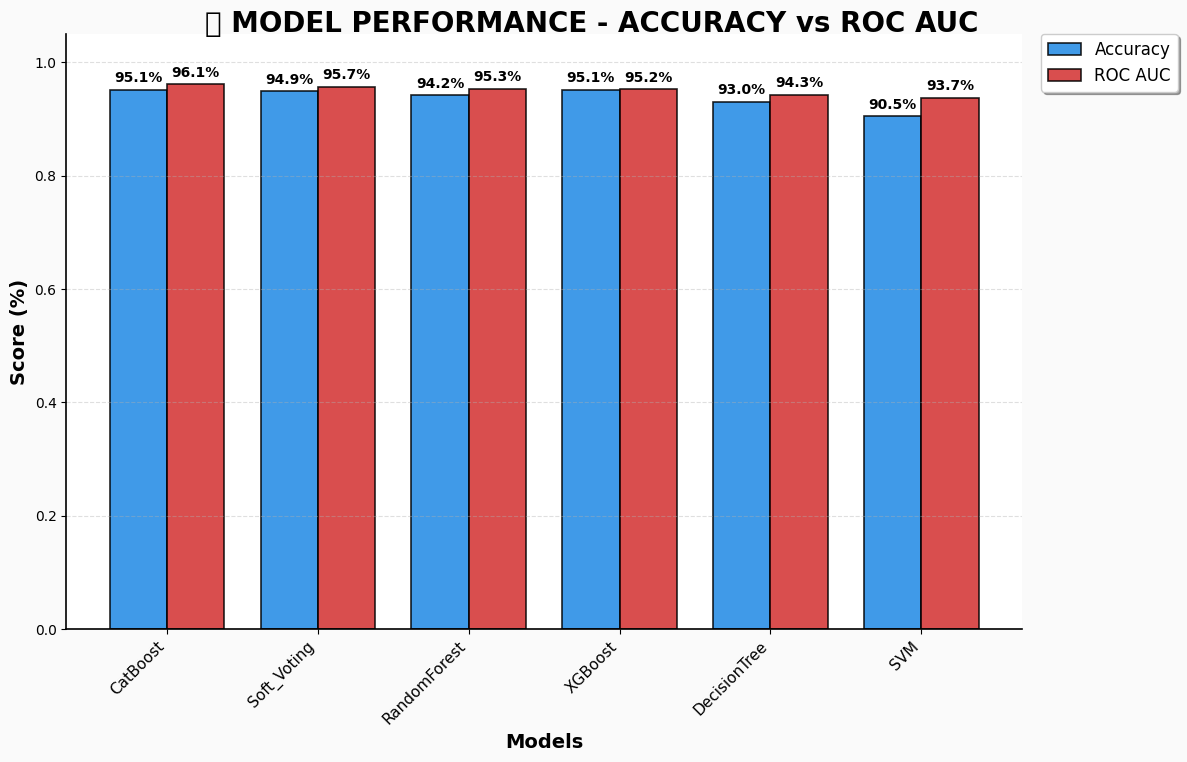

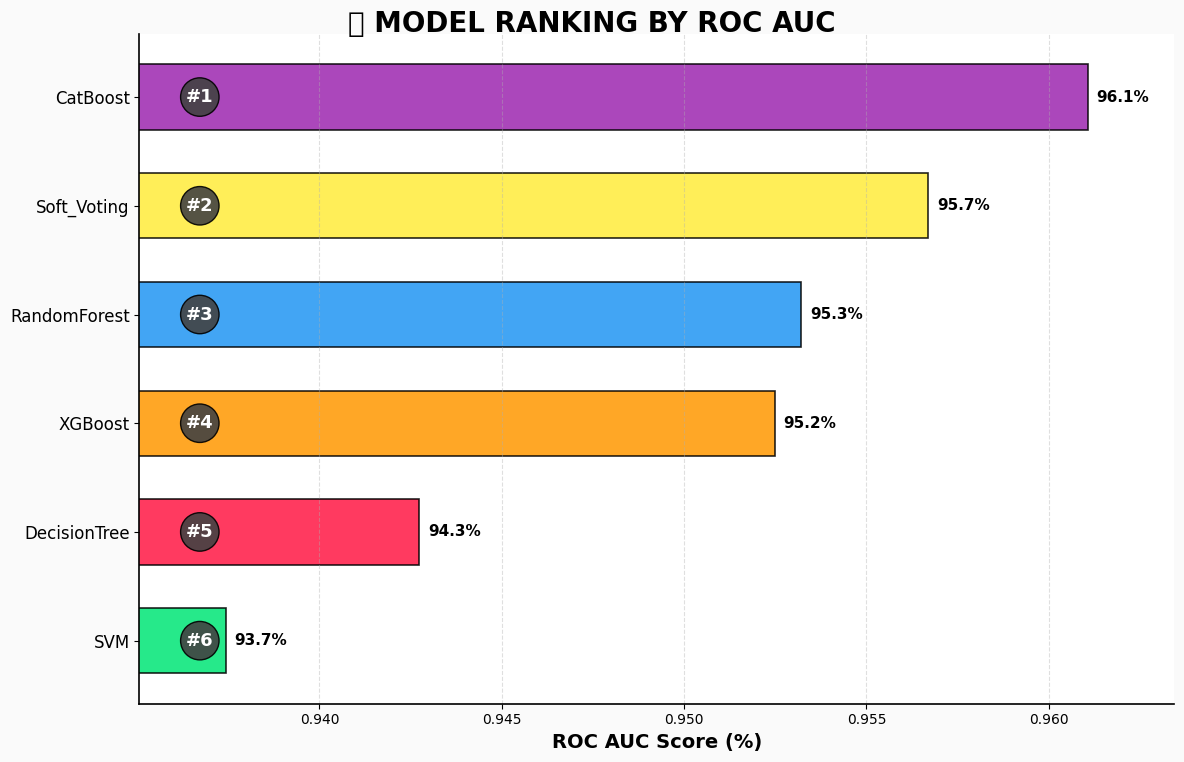


📊 MODEL PERFORMANCE SUMMARY
Model           Accuracy   ROC AUC    Rank  
------------------------------------------------------------
CatBoost        95.12%     96.11%     #1
Soft_Voting     94.88%     95.67%     #2
RandomForest    94.19%     95.32%     #3
XGBoost         95.12%     95.25%     #4
DecisionTree    93.02%     94.27%     #5
SVM             90.47%     93.74%     #6

🏆 BEST MODEL: CatBoost
   ROC AUC: 96.11%
   Accuracy: 95.12%


In [14]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def create_model_comparison_charts_separate(model_performance, figsize=(12, 8)):
    """
    Create two separate charts to compare model performance:
    1. Grouped bar chart showing Accuracy and ROC AUC scores side-by-side.
    2. Horizontal bar chart ranking models by ROC AUC score.

    Additionally, prints a formatted summary table with model rankings.

    Parameters:
    - model_performance (dict): Dictionary with model names as keys and metric dicts as values.
      Each metric dict should include 'accuracy' and 'roc_auc' scores at minimum.
    - figsize (tuple): Figure size for the plots.

    Returns:
    - pandas.DataFrame: DataFrame containing model names and their Accuracy and ROC AUC scores,
      sorted by ROC AUC descending.
    """

    # Extract model names and their corresponding accuracy and ROC AUC scores
    models = list(model_performance.keys())
    accuracy_scores = [model_performance[model]['accuracy'] for model in models]
    roc_auc_scores = [model_performance[model]['roc_auc'] for model in models]

    # Create a DataFrame for easier data manipulation and plotting
    comparison_df = pd.DataFrame({
        'Model': models,
        'Accuracy': accuracy_scores,
        'ROC_AUC': roc_auc_scores
    })

    # Sort models by ROC AUC score descending for ranking
    comparison_df = comparison_df.sort_values('ROC_AUC', ascending=False)

    # Define distinct vibrant colors for known models to improve chart readability
    colors = {
        'DecisionTree': '#FF1744',      # Bright Red
        'SVM': '#00E676',               # Bright Green
        'RandomForest': '#2196F3',      # Bright Blue
        'XGBoost': '#FF9800',           # Bright Orange
        'CatBoost': '#9C27B0',          # Bright Purple
        'Hard_Voting': '#00BCD4',       # Bright Cyan
        'Soft_Voting': '#FFEB3B'        # Bright Yellow
    }

    # Map colors to the models in the sorted DataFrame, use default grey if not found
    model_colors = [colors.get(model, '#607D8B') for model in comparison_df['Model']]

    # ========== CHART 1: Grouped Bar Chart for Accuracy and ROC AUC ==========
    fig1, ax1 = plt.subplots(1, 1, figsize=figsize)
    fig1.suptitle('📊 MODEL PERFORMANCE - ACCURACY vs ROC AUC', fontsize=20, fontweight='bold', y=0.95)

    x_pos = np.arange(len(comparison_df))  # X locations for the groups
    width = 0.38  # Width of the bars

    # Bars for Accuracy scores, styled with blue color and black edges
    bars1 = ax1.bar(x_pos - width/2, comparison_df['Accuracy'], width,
                    label='Accuracy', color='#1E88E5', alpha=0.85, edgecolor='black', linewidth=1.2)
    # Bars for ROC AUC scores, styled with red color and black edges
    bars2 = ax1.bar(x_pos + width/2, comparison_df['ROC_AUC'], width,
                    label='ROC AUC', color='#D32F2F', alpha=0.85, edgecolor='black', linewidth=1.2)

    # Label x and y axes with bold font and decent font size
    ax1.set_xlabel('Models', fontweight='bold', fontsize=14)
    ax1.set_ylabel('Score (%)', fontweight='bold', fontsize=14)

    # Set the ticks on x-axis to model names, rotated for readability
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels(comparison_df['Model'], rotation=45, ha='right', fontsize=11)

    # Add legend outside plot area to the right
    ax1.legend(fontsize=12, bbox_to_anchor=(1.02, 1), loc='upper left',
               borderaxespad=0., frameon=True, fancybox=True, shadow=True)

    # Adjust layout to ensure the legend fits nicely
    fig1.tight_layout(rect=[0, 0, 0.85, 0.95])

    # Add horizontal grid lines only on y-axis for easier reading
    ax1.grid(axis='y', alpha=0.4, linestyle='--')

    # Limit y-axis from 0 to slightly above 1 for percentage-style display
    ax1.set_ylim(0, 1.05)

    # Add numeric labels above each bar for clarity - NOW AS PERCENTAGES
    for bar in bars1:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.008,
                 f'{height*100:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=10)

    for bar in bars2:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.008,
                 f'{height*100:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=10)

    # Apply subtle styling to figure and axes background and borders
    fig1.patch.set_facecolor('#FAFAFA')
    ax1.set_facecolor('#FFFFFF')
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['left'].set_linewidth(1.2)
    ax1.spines['bottom'].set_linewidth(1.2)

    plt.tight_layout()
    plt.show()

    # ========== CHART 2: Horizontal Bar Chart Ranking by ROC AUC ==========
    fig2, ax2 = plt.subplots(1, 1, figsize=figsize)
    fig2.suptitle('🥇 MODEL RANKING BY ROC AUC', fontsize=20, fontweight='bold', y=0.95)

    # Horizontal bars colored according to model_colors list
    bars3 = ax2.barh(range(len(comparison_df)), comparison_df['ROC_AUC'],
                     color=model_colors, alpha=0.85, edgecolor='black', linewidth=1.2, height=0.6)

    # Set y-ticks to model names and invert y-axis to have best model on top
    ax2.set_yticks(range(len(comparison_df)))
    ax2.set_yticklabels(comparison_df['Model'], fontsize=12)
    ax2.set_xlabel('ROC AUC Score (%)', fontweight='bold', fontsize=14)
    ax2.invert_yaxis()

    # Add vertical grid lines for x-axis for readability
    ax2.grid(axis='x', alpha=0.4, linestyle='--')

    # Set x-axis limits dynamically with a small margin for label visibility
    min_roc = comparison_df['ROC_AUC'].min()
    max_roc = comparison_df['ROC_AUC'].max()
    margin = (max_roc - min_roc) * 0.1
    ax2.set_xlim(max(0, min_roc - margin), min(1, max_roc + margin))

    # Add value labels to each horizontal bar - NOW AS PERCENTAGES
    for i, bar in enumerate(bars3):
        width = bar.get_width()
        ax2.text(width + (max_roc - min_roc) * 0.01, bar.get_y() + bar.get_height()/2,
                 f'{width*100:.1f}%', ha='left', va='center', fontweight='bold', fontsize=11)

    # Add rank numbers as circles to the left of bars for visual emphasis
    for i, (_, row) in enumerate(comparison_df.iterrows()):
        ax2.text(min_roc - margin * 0.3, i, f'#{i+1}', ha='center', va='center',
                 fontweight='bold', fontsize=13, color='white',
                 bbox=dict(boxstyle='circle,pad=0.3', facecolor='#424242', alpha=0.9))

    # Style the second chart similarly to the first one
    fig2.patch.set_facecolor('#FAFAFA')
    ax2.set_facecolor('#FFFFFF')
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['left'].set_linewidth(1.2)
    ax2.spines['bottom'].set_linewidth(1.2)

    plt.tight_layout()
    plt.show()

    # ========== SUMMARY TABLE PRINT ==========
    print("\n" + "="*60)
    print("📊 MODEL PERFORMANCE SUMMARY")
    print("="*60)
    print(f"{'Model':<15} {'Accuracy':<10} {'ROC AUC':<10} {'Rank':<6}")
    print("-" * 60)

    # Print each model with its metrics and rank (sorted by ROC AUC) - AS PERCENTAGES
    for i, (_, row) in enumerate(comparison_df.iterrows(), 1):
        print(f"{row['Model']:<15} {row['Accuracy']*100:.2f}%     {row['ROC_AUC']*100:.2f}%     #{i}")

    # Print best model info separately - AS PERCENTAGES
    best_model = comparison_df.iloc[0]
    print(f"\n🏆 BEST MODEL: {best_model['Model']}")
    print(f"   ROC AUC: {best_model['ROC_AUC']*100:.2f}%")
    print(f"   Accuracy: {best_model['Accuracy']*100:.2f}%")

    return comparison_df


comparison_df = create_model_comparison_charts_separate(model_performance)


🔍 SHAP ANALYSIS FOR MODEL INTERPRETABILITY

📊 Creating SHAP explainer for CatBoost...
🌳 Using TreeExplainer for CatBoost...
🔄 Computing SHAP values for test set...
⏳ This may take a few minutes for ensemble models...
✅ Final SHAP values shape: (100, 10)
✅ SHAP values computed for 100 test samples

📊 Generating SHAP visualizations...


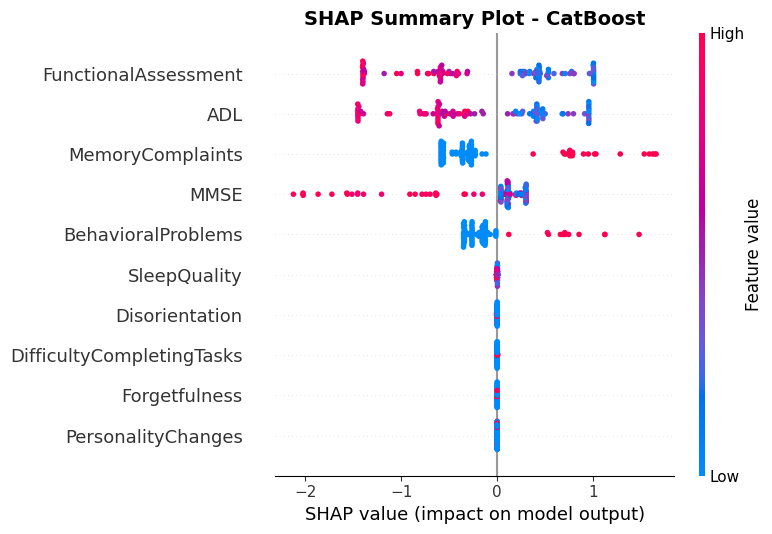

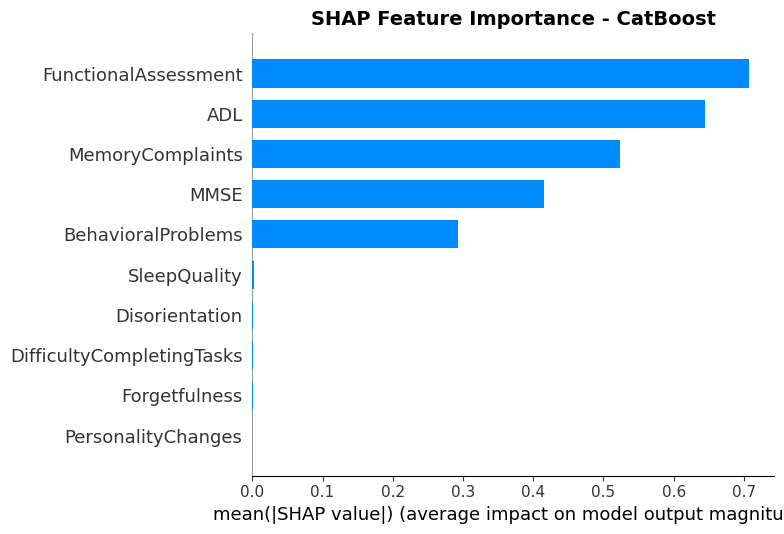


🌊 Individual prediction explanations (first 3 test samples):


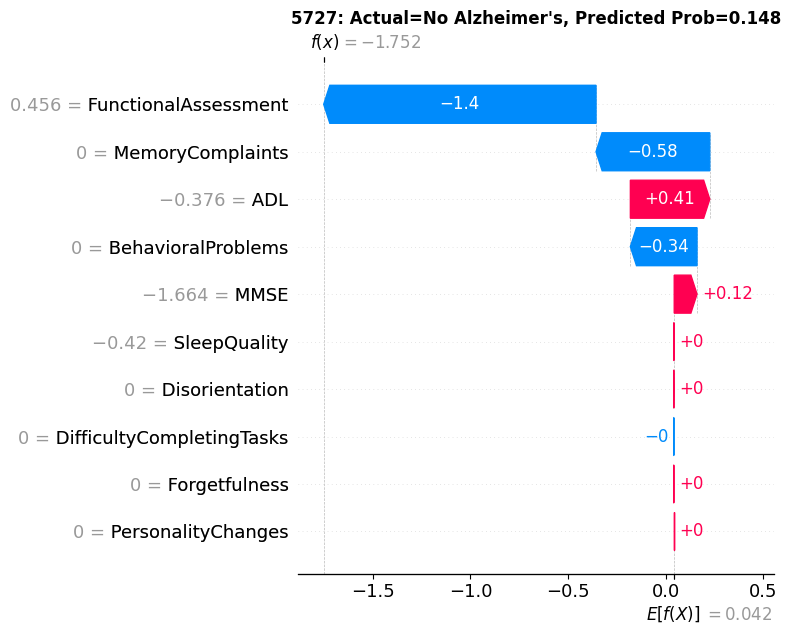

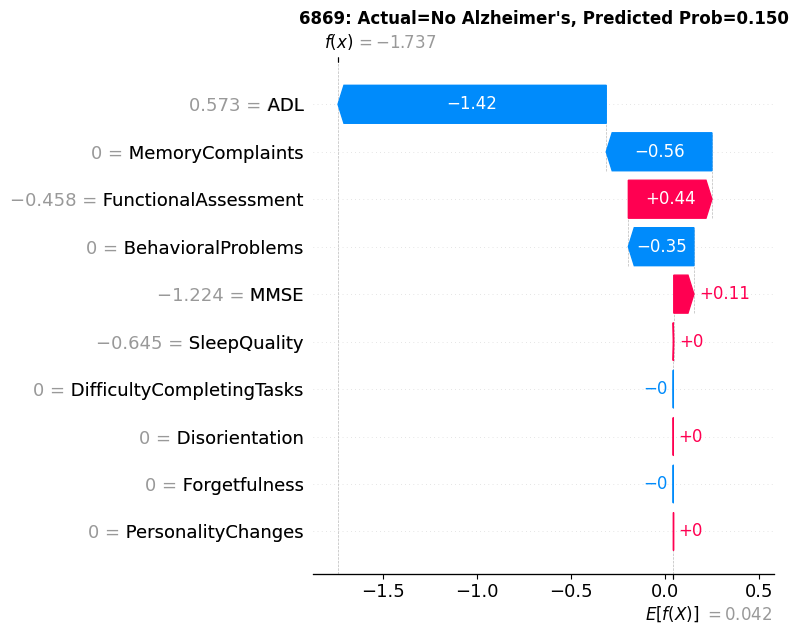

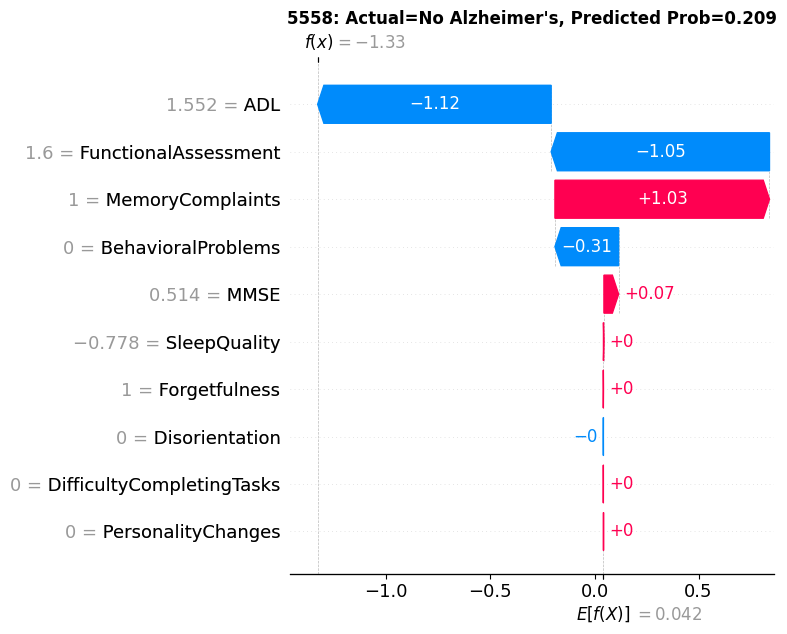

In [15]:
import shap
from sklearn.inspection import permutation_importance
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

# Disable interactive plotting to prevent empty figures popping up automatically
plt.ioff()

"""
SHAP ANALYSIS FOR MODEL INTERPRETABILITY
This section performs explainability analysis using SHAP values
to understand feature contributions to model predictions.
"""

print("\n" + "="*80)
print("🔍 SHAP ANALYSIS FOR MODEL INTERPRETABILITY")
print("="*80)

print(f"\n📊 Creating SHAP explainer for {best_model_name}...")

# ------------------------------
# Select the appropriate SHAP explainer
# ------------------------------
if 'Voting' in best_model_name:
    # Voting classifiers require KernelExplainer with a background dataset
    print("🔄 Detected Voting Classifier - using KernelExplainer with background dataset...")
    background_sample = shap.sample(X_train_top_balanced, min(100, len(X_train_top_balanced)))

    # Define prediction function for KernelExplainer
    def model_predict_proba(X):
        return best_model.predict_proba(X)

    explainer = shap.KernelExplainer(model_predict_proba, background_sample)

elif best_model_name in ['RandomForest', 'XGBoost', 'CatBoost']:
    # Tree-based models are compatible with TreeExplainer (fast and accurate)
    print(f"🌳 Using TreeExplainer for {best_model_name}...")
    explainer = shap.TreeExplainer(best_model)

elif best_model_name == 'SVM':
    # SVM requires KernelExplainer due to non-tree nature
    print("🔵 Using KernelExplainer for SVM...")
    background_sample = shap.sample(X_train_top_balanced, min(100, len(X_train_top_balanced)))
    explainer = shap.KernelExplainer(best_model.predict_proba, background_sample)

elif best_model_name == 'DecisionTree':
    # Decision Tree models can use TreeExplainer
    print("🌲 Using TreeExplainer for Decision Tree...")
    explainer = shap.TreeExplainer(best_model)

else:
    # Fallback: use KernelExplainer for unknown model types
    print(f"🔄 Using KernelExplainer for {best_model_name}...")
    background_sample = shap.sample(X_train_top_balanced, min(100, len(X_train_top_balanced)))
    explainer = shap.KernelExplainer(best_model.predict_proba, background_sample)

# ------------------------------
# Compute SHAP values on a test subset
# ------------------------------
print("🔄 Computing SHAP values for test set...")
test_sample_size = min(100, len(X_test_top_preprocessed))
test_sample_indices = np.random.choice(len(X_test_top_preprocessed), test_sample_size, replace=False)
X_test_sample = X_test_top_preprocessed[test_sample_indices]
y_test_sample = y_test_top.iloc[test_sample_indices]

print("⏳ This may take a few minutes for ensemble models...")

try:
    # Calculate SHAP values based on explainer type
    if 'Voting' in best_model_name or best_model_name == 'SVM':
        shap_values = explainer.shap_values(X_test_sample)
        # Handle multi-output list (binary classification)
        if isinstance(shap_values, list):
            shap_values = shap_values[1] if len(shap_values) == 2 else shap_values[0]
        # Handle 3D output
        elif len(shap_values.shape) == 3:
            shap_values = shap_values[:, :, 1]
    else:
        shap_values = explainer.shap_values(X_test_sample)
        if isinstance(shap_values, list):
            shap_values = shap_values[1] if len(shap_values) == 2 else shap_values[0]

    shap_values = np.array(shap_values)
    if len(shap_values.shape) != 2:
        raise ValueError(f"Unexpected SHAP values shape: {shap_values.shape}")

    print(f"✅ Final SHAP values shape: {shap_values.shape}")
    print(f"✅ SHAP values computed for {test_sample_size} test samples")

except Exception as e:
    print(f"❌ Error computing SHAP values: {e}")
    print("🔄 Trying alternative approach with smaller sample...")

    # Fallback: smaller subset if computation fails
    small_sample_size = min(10, len(X_test_top_preprocessed))
    small_sample_indices = np.random.choice(len(X_test_top_preprocessed), small_sample_size, replace=False)
    X_test_small = X_test_top_preprocessed[small_sample_indices]

    try:
        shap_values = explainer.shap_values(X_test_small)
        if isinstance(shap_values, list):
            shap_values = shap_values[1] if len(shap_values) == 2 else shap_values[0]

        test_sample_size = small_sample_size
        test_sample_indices = small_sample_indices
        X_test_sample = X_test_small
        y_test_sample = y_test_top.iloc[small_sample_indices]

        print(f"✅ Fallback successful with {small_sample_size} samples")

    except Exception as e2:
        print(f"❌ Fallback also failed: {e2}")
        print("⚠️  Skipping SHAP analysis due to compatibility issues")
        exit()  # Stop SHAP analysis

# ------------------------------
# Prepare feature names
# ------------------------------
feature_names = numerical_top + categorical_top
# Add generic names if additional features exist
while len(feature_names) < X_test_sample.shape[1]:
    feature_names.append(f'feature_{len(feature_names)}')

print("\n📊 Generating SHAP visualizations...")

# ------------------------------
# SHAP Summary Plots
# ------------------------------
# Beeswarm plot (detailed feature impact)
fig, ax = plt.subplots(figsize=(12, 8))
shap.summary_plot(shap_values, X_test_sample, feature_names=feature_names, show=False)
plt.title(f'SHAP Summary Plot - {best_model_name}', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()
plt.close(fig)

# Bar plot (overall feature importance)
fig, ax = plt.subplots(figsize=(12, 8))
shap.summary_plot(shap_values, X_test_sample, feature_names=feature_names, plot_type="bar", show=False)
plt.title(f'SHAP Feature Importance - {best_model_name}', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()
plt.close(fig)

# ------------------------------
# Compute global feature importance
# ------------------------------
try:
    feature_importance = np.abs(shap_values).mean(0)
    feature_names = feature_names[:len(feature_importance)]
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'SHAP_Importance': feature_importance
    }).sort_values('SHAP_Importance', ascending=False)

except Exception as e:
    print(f"❌ Error calculating feature importance: {e}")
    feature_importance = np.abs(shap_values).mean(0)
    importance_df = pd.DataFrame({
        'Feature': [f'Feature_{i}' for i in range(len(feature_importance))],
        'SHAP_Importance': feature_importance
    }).sort_values('SHAP_Importance', ascending=False)

# ------------------------------
# Individual patient explanations (waterfall plots)
# ------------------------------
print(f"\n🌊 Individual prediction explanations (first 3 test samples):")

try:
    for i in range(min(3, len(X_test_sample))):
        # Safely extract expected value
        try:
            if 'Voting' in best_model_name:
                base_value = float(explainer.expected_value[1]) if len(explainer.expected_value) > 1 else float(explainer.expected_value[0])
            else:
                base_value = float(explainer.expected_value) if np.isscalar(explainer.expected_value) else float(explainer.expected_value[0])
        except:
            base_value = float(np.mean(shap_values))

        # Create SHAP explanation object
        explanation = shap.Explanation(
            values=shap_values[i],
            base_values=base_value,
            data=X_test_sample[i],
            feature_names=feature_names[:len(shap_values[i])]
        )

        actual_label = "Alzheimer's" if y_test_sample.iloc[i] == 1 else "No Alzheimer's"

        # Get predicted probability
        try:
            predicted_proba = best_model.predict_proba(X_test_sample[i:i+1])[0, 1] if hasattr(best_model, 'predict_proba') else 0.5
        except:
            predicted_proba = 0.5

        original_test_idx = test_sample_indices[i]
        if 'test_data_with_ids' in globals() and test_data_with_ids is not None and 'PatientID' in test_data_with_ids.columns:
            patient_id = int(test_data_with_ids.iloc[original_test_idx]['PatientID'])
        else:
            patient_id = f"Patient_{original_test_idx}"

        # Plot waterfall
        fig, ax = plt.subplots(figsize=(10, 6))
        shap.waterfall_plot(explanation, show=False)
        plt.title(f'{patient_id}: Actual={actual_label}, Predicted Prob={predicted_proba:.3f}',
                  fontsize=12, fontweight='bold')
        plt.tight_layout()
        plt.show()
        plt.close(fig)

except Exception as e:
    print(f"❌ Error creating waterfall plots: {e}")
    print("⚠️  Skipping waterfall plots due to compatibility issues")


In [16]:
import joblib
import os

# Define your output folder path
output_folder = "/Users/swehavenkateshwari/Alzheimer_Prediction_Project/alzheimers_model_files"

# Create the output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

print("💾 Saving model components...")

# Save the main components
joblib.dump(best_model, os.path.join(output_folder, 'alzheimers_best_model.pkl'))
joblib.dump(preprocessor_top, os.path.join(output_folder, 'alzheimers_preprocessor_top10.pkl'))
joblib.dump(feature_names, os.path.join(output_folder, 'alzheimers_feature_names_processed.pkl'))
joblib.dump(explainer, os.path.join(output_folder, 'alzheimers_shap_explainer.pkl'))


joblib.dump(top_10_features, os.path.join(output_folder, 'alzheimers_top10_features.pkl'))

# Save performance metrics
joblib.dump(model_performance, os.path.join(output_folder, 'alzheimers_model_performance.pkl'))

print("✅ All model files saved successfully!")
print(f"📁 Location: {output_folder}")

💾 Saving model components...
✅ All model files saved successfully!
📁 Location: /Users/swehavenkateshwari/Alzheimer_Prediction_Project/alzheimers_model_files
